In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import sklearn.cluster as skclust 
import copy
import scipy.stats as spstat

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_ind_fitnesses(filename):
    with open(filename) as file:
        csv_data = csv.reader(file,delimiter=',')
        lines = []
        for row in csv_data:
            for i in range(3,int(row[1])+3):
                lines.append([int(row[0]),i-3,float(row[i])])
    return lines

def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                lines.append([coord[0],coord[1],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of joints","number of sensors","fitness"])
                
def load_number_of_eval_per_gen(foldername,nbr_gen):
    nbr_eval_per_gen = [0]*nbr_gen
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            nbr_eval = 0
            for row in csv_data:
                if(len(row) == 4):
                    nbr_eval+=1
        nbr_eval_per_gen[gen] += nbr_eval
   # for i in range(1,len(nbr_eval_per_gen)):
    #    nbr_eval_per_gen[i] += nbr_eval_per_gen[i-1]
    return nbr_eval_per_gen
    
def load_controllers_fitnesses(foldername,nbr_gen):
    init_fits = [[] for _ in range(nbr_gen)]
    best_fits = [[] for _ in range(nbr_gen)]
    learn_prog = [[] for _ in range(nbr_gen)]
    learn_delta = [[] for _ in range(nbr_gen)]
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            best_fit = 0
            init_fit = 0
            counter = 0
            for row in csv_data:
                if(len(row) == 2):
                    if(init_fit == 0):
                        init_fit = float(row[0])
                        if(init_fit < 0):
                            init_fit = 0.5
                    if(best_fit < float(row[0])):
                        best_fit = float(row[0])
                    counter+=1
            learn_prog[gen].append((best_fit - init_fit))
            learn_delta[gen].append((best_fit - init_fit)/counter)
            best_fits[gen].append(best_fit)
            init_fits[gen].append(init_fit)
            
        
    return best_fits, init_fits ,learn_delta, learn_prog    
    
    
def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def descOneId_to_descTwoIds(descriptors,pop_size):
    descriptors2 = []
    gen = 0
    ind = 0
    for desc in descriptors:
        if(desc[0] != 0 and desc[0]%pop_size == 0):
            gen+=1
            ind=0
        desc2 = [gen,ind] + desc[1:]
        ind+=1
        descriptors2.append(desc2)
    return descriptors2
        
def descriptors_to_nbr_of_types(descriptors):
    types_lines = []
    acc = 0
    mat = [[[0 for _ in range(16)] for _ in range(16)] for _ in range(16)]
    for desc in descriptors:
        if(mat[int(desc[6]*16)][int(desc[7]*16)][int(desc[8]*16)] == 0):
            mat[int(desc[6]*16)][int(desc[7]*16)][int(desc[8]*16)] = 1
            acc+=1
        if(desc[1] == 0):
            type_lines.append([desc[0],acc])
    return type_lines

def sparsness_per_gen(descriptors,pop_size):
    sparsness = []
    for i in range(int(len(descriptors)/pop_size)):
        tmp_desc = descriptors[i*pop_size:(i+1)*pop_size]
        spars = 0
        for o in range(len(tmp_desc)):
            for p in range(len(tmp_desc)):
                if(o==p):
                    continue
                dist = np.linalg.norm(np.array(tmp_desc[o][3:])-np.array(tmp_desc[p][3:]))
            spars += dist
        sparsness.append([i,spars/10])
    return sparsness

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

def plot_hist_nbr_rob(title,data,organ,bins,nb_rob):
    fig = plt.gcf()
    fig.set_size_inches(25,10)
    ax = sns.histplot(data=data,multiple="stack",bins=bins,x='gen',hue=organ,palette="light:b")
    ax.set_ylabel("Number of robots",fontsize=20)
    ax.set_xlabel("Generations",fontsize=20)
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(range(1,nb_rob+1),labels=[1]*nb_rob,fontsize=20)
    plt.show()
    
    
def acc_number_eval(nbr_eval, best_fit):
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            return acc_nbr_eval, ne
        
def fitness_per_descriptor(descriptors,fitnesses):
    fit_per_desc = [dict() for _ in range(int(len(fitnesses)/20))]
    for fit,desc in zip(fitnesses,descriptors):
        if(fit[0] == desc[0] and fit[1] == desc[1]):
            organ_desc = str(int(desc[6]*16))+str(int(desc[7]*16)) + str(int(desc[8]*16))
            if(organ_desc in fit_per_desc[fit[0]]):
                fit_per_desc[fit[0]][organ_desc].append(fit[2])
            else:
                fit_per_desc[fit[0]][organ_desc] = [fit[2]]
    return fit_per_desc

def best_desc_per_gen(descriptors,fitnesses):
    best_fit = 0
    best_idx = 0
    best_desc = []
    for fit,i in zip(fitnesses,range(len(fitnesses))):
        if(fit[1] == 0 and fit[0] != 0):
            best_fit = 0
            best_desc.append([fit[0]-1,int(descriptors[best_idx][6]*16),int(descriptors[best_idx][7]*16),int(descriptors[best_idx][8]*16)])         
        if(fit[2] > best_fit):
            best_fit = fit[2]
            best_idx = i

    return best_desc
                     

In [5]:
nb_eval_lines = []

In [11]:
arena="Amphitheatre"

In [12]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/wa/100/"

In [59]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 100",bff_ne])
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=0
        for i,line in ctrl_arch.iterrows():
            ctrl_fit+=line["fitness"]
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit/nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])

    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    
    for gen, bf, af, nc,cf,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,ctrl_fit_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,nc,cf,ne,np.mean(lp),np.max(lp)])
wa_c_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","average fitness in controller archive","number of evaluations","average learning progress","best learning progress"])

20
22760
40
32280
20
32850
20
22990
40
28810
20
23820
40
34470
40
44230
20
21540
40
46720


In [176]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

TypeError: load_ind_fitnesses() takes 1 positional argument but 2 were given

In [177]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","100"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","100"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","100"])

TypeError: load_descriptor() takes 1 positional argument but 2 were given

In [60]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/na/100/"

In [61]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 100",bff_ne,acc_nbr_eval[-1]])
            
    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,init_f,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,np.mean(initf),np.max(initf),af,ane,ne,np.mean(lp),np.max(lp)])
na_c_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average initial fitness","best initial fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

40
37610
40
45360
40
45210
40
43020
40
68760
40
36620
40
40500
40
46760


In [182]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/wa/200/"

In [183]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 200",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    for i in range(len(fitnesses)):
        fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
            organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
            if(organ_desc in fit_per_desc[gen_v[-1]]):
                for fit in fit_per_desc[gen_v[-1]][organ_desc]:
                    diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,fd,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,fit_diff_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*4000,
                      bf,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      np.mean(fd),
                      np.max(fd),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average fitness in controller archive",
                                              "best fitness in controller archive",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

20
29600
20
39020
20
38930
20
38800
20
56090
20
50960
20
33570
20
67420
20
62060
20
49990


(0, 60)

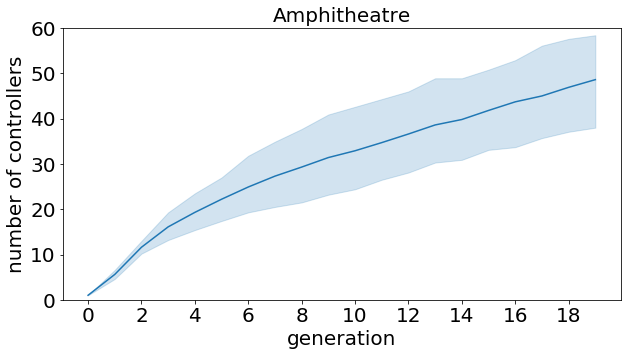

In [77]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=wa_dc_data,x="generation",y="number of controllers")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_ylim([0,60])

(0, 1.0)

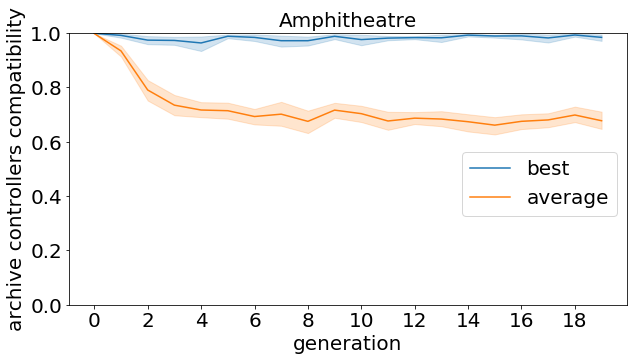

In [80]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best archive controllers compatibility",label="best")
ax = sns.lineplot(data=wa_dc_data,x="generation",y="average archive controllers compatibility",label="average")
ax.set_ylabel("archive controllers compatibility")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.0,0.6,0,0))
ax.set_ylim([0,1.0])

(0.6, 1)

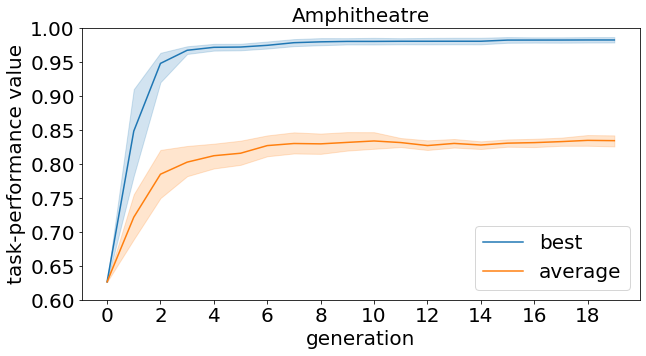

In [81]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness in controller archive",label="best")
ax = sns.lineplot(data=wa_dc_data,x="generation",y="average fitness in controller archive",label="average")
ax.set_ylabel("task-performance value")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([0.6,1])

In [318]:
organ_lines = []
arena="Amphitheatre"
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/wa/200/"

In [319]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    if(fit[2] >= 0.85):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100

    
for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MELAI"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MELAI"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MELAI"])

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 7 Text yticklabel objects>)

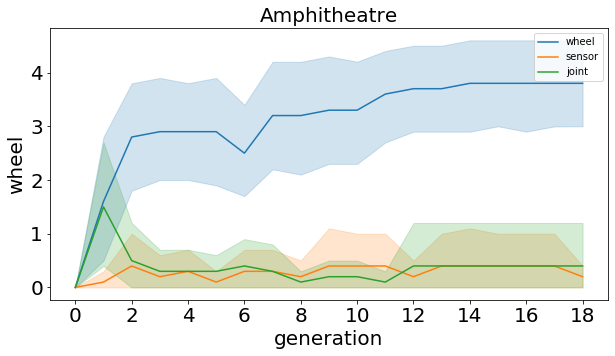

In [321]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [306]:
exp_folder = "/home/leni/are-logs/mea_rand/steps/"

In [307]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))

    for gen, bf, af in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,gen*2000,bf,af])
rand_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness"])

41
41
41
41
41
41
41
41
41
41


In [310]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    descriptors = descOneId_to_descTwoIds(descriptors,20)
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    if(fit[2] >= 0.85):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MELR"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MELR"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MELR"])

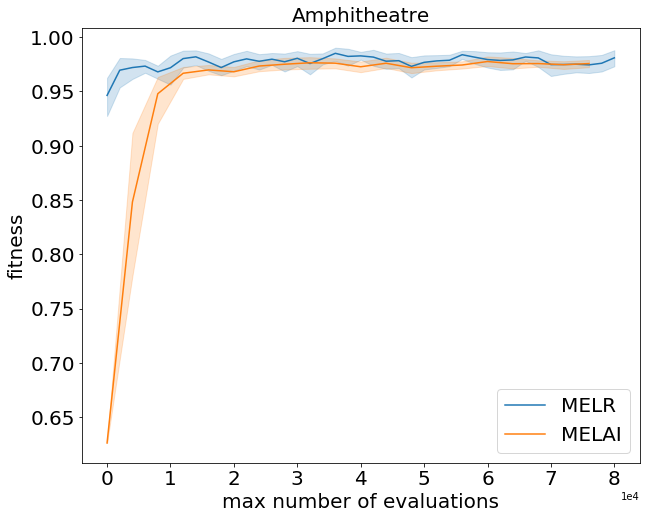

In [217]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
ax = sns.lineplot(data=rand_data,x="max number of evaluations",y="best fitness",label="MELR")
sns.lineplot(data=wa_dc_data,x="max number of evaluations",y="best fitness",label="MELAI")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("fitness")
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

<Figure size 360x360 with 0 Axes>

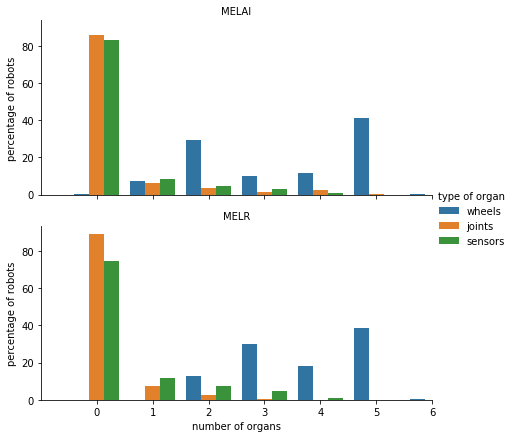

In [218]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 6))) 

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <a list of 10 Text yticklabel objects>)

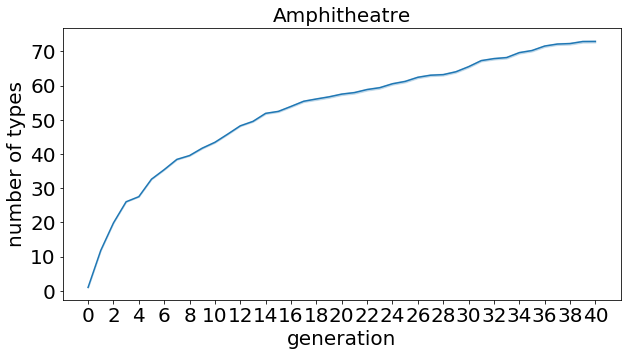

In [219]:
type_data = pd.DataFrame(data=type_lines,columns=["generation","number of types"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=type_data,x="generation",y="number of types")
ax.set_xticks(range(0,42,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text yticklabel objects>)

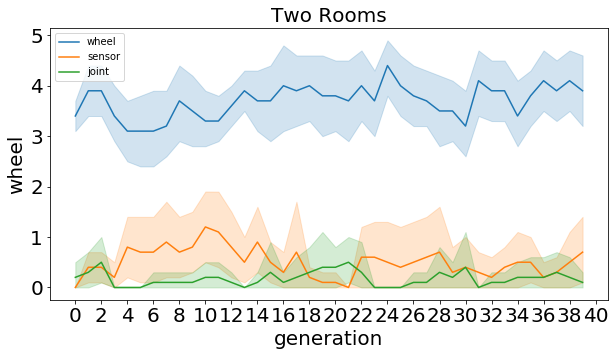

In [312]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
ax.set_xticks(range(0,42,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [154]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/na/200/"

In [155]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 200",bff_ne,acc_nbr_eval[-1]])
            
    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,init_f,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,np.mean(initf),np.max(initf),af,ane,ne,np.mean(lp),np.max(lp)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average initial fitness","best initial fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

20
39500
20
38880
20
77900
20
51370
20
55730
20
39870
20
46900
20
50190
20
47090
20
44620


In [128]:
d1 = wa_dc_data["best initial fitness"].to_numpy()
d2 = na_dc_data["best initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
d1 = wa_dc_data["average initial fitness"].to_numpy()
d2 = na_dc_data["average initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
d1 = wa_dc_data["best fitness"].to_numpy()
d2 = na_dc_data["best fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

40000
MannwhitneyuResult(statistic=12341.0, pvalue=1.7458957642127478e-11)
40000
MannwhitneyuResult(statistic=17714.0, pvalue=0.024030336318530358)
40000
MannwhitneyuResult(statistic=12675.5, pvalue=1.1878004599904853e-10)


(0.6, 1)

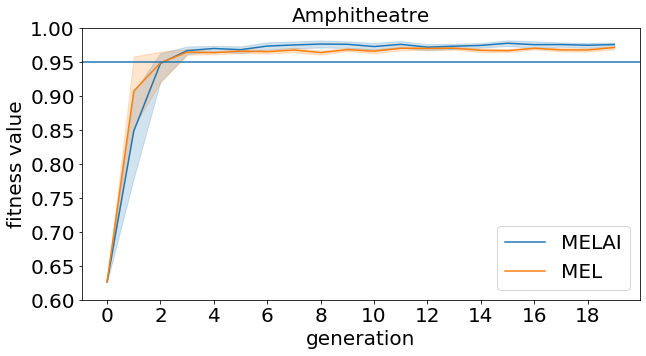

In [84]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="MEL")
ax.axhline([0.95])
ax.set_ylabel("fitness value")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([0.6,1])

(0.6, 1)

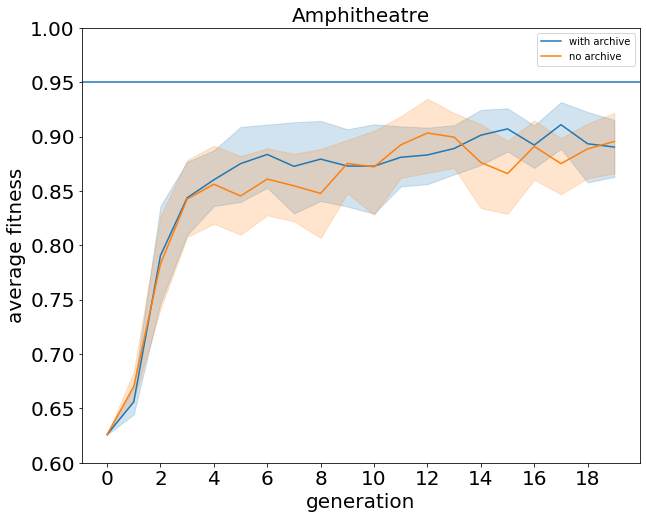

In [22]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_ylim([0.6,1])

100
MannwhitneyuResult(statistic=15.0, pvalue=0.004554248199015482)
100
MannwhitneyuResult(statistic=48.0, pvalue=0.45486094457277765)


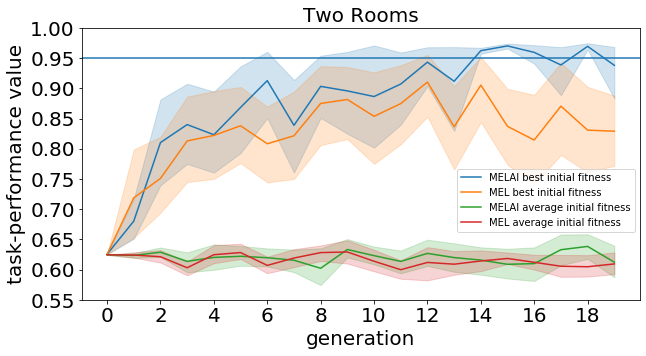

In [146]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best initial fitness",label="MELAI best initial fitness")
sns.lineplot(data=na_dc_data,x="generation",y="best initial fitness",label="MEL best initial fitness")
sns.lineplot(data=wa_dc_data,x="generation",y="average initial fitness",label="MELAI average initial fitness")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average initial fitness",label="MEL average initial fitness")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("task-performance value")
ax.set_ylim([0.55,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=10,bbox_to_anchor=(1.,0.5,0,0))
d1 = wa_dc_data[wa_dc_data["generation"]==19]["best initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["best initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
d1 = wa_dc_data[wa_dc_data["generation"]==19]["average initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["average initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

100
MannwhitneyuResult(statistic=50.0, pvalue=0.4849249884965778)


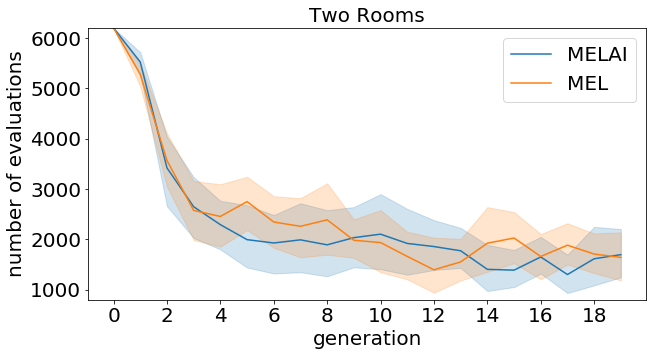

In [147]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="MEL")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([800,6200])
d1 = wa_dc_data[wa_dc_data["generation"]==19]["number of evaluations"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["number of evaluations"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

100
MannwhitneyuResult(statistic=22.0, pvalue=0.01881765689365712)


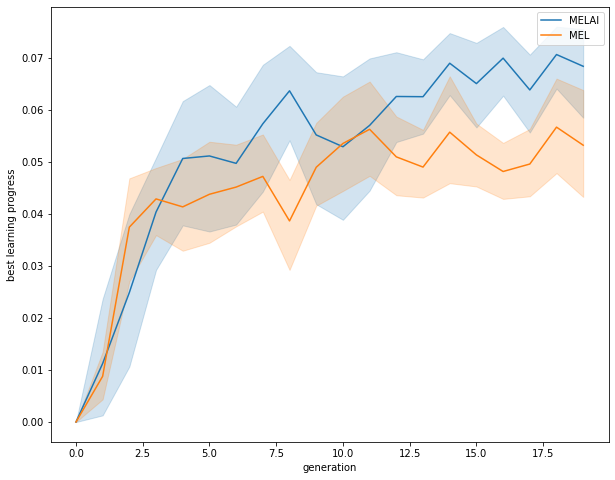

In [148]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="MEL")
d1 = wa_dc_data[wa_dc_data["generation"]==19]["best learning progress"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["best learning progress"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

100
MannwhitneyuResult(statistic=36.0, pvalue=0.15374472830934066)


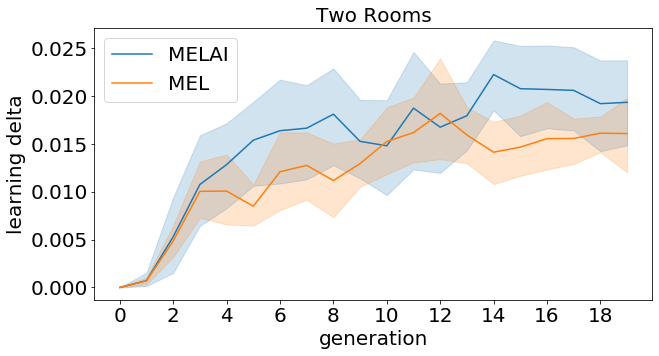

In [149]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="average learning progress",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average learning progress",label="MEL")
ax.set_ylabel("learning delta")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
d1 = wa_dc_data[wa_dc_data["generation"]==19]["average learning progress"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["average learning progress"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

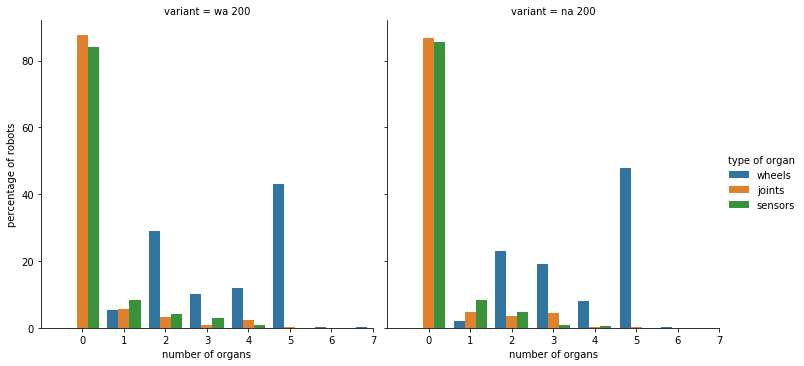

In [121]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

In [66]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/wa/150/"

In [67]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))

    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 150",bff_ne,acc_nbr_eval[-1]])
            
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*3000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

30
29780
30
57420
30
41730
30
60610
30
50220
30
26730
30
27860
30
27930
30
36740
30
57420


In [126]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [127]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","wa 150"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","wa 150"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","wa 150"])

3000


In [68]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/na/150/"

In [69]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]

    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 150",bff_ne,acc_nbr_eval[-1]])
            
    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,ne,np.mean(lp),np.max(lp)])
na_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

30
39360
30
37520
30
38110
30
31370
30
45350
30
40730
30
33620
30
57650
30
78640
30
51480


(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 <a list of 10 Text yticklabel objects>)

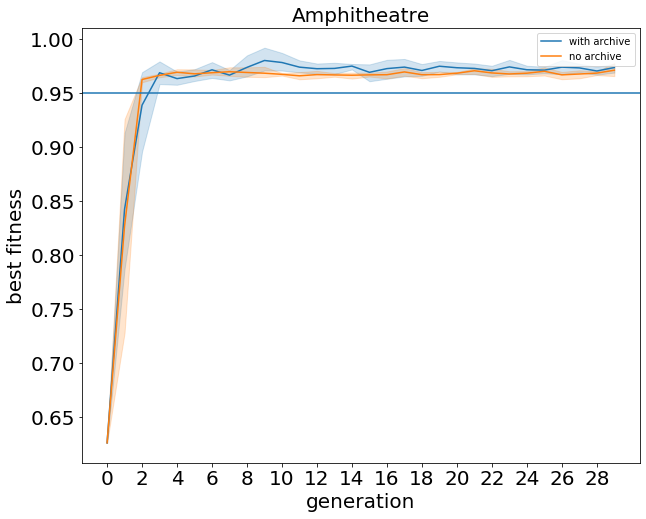

In [138]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 9 Text yticklabel objects>)

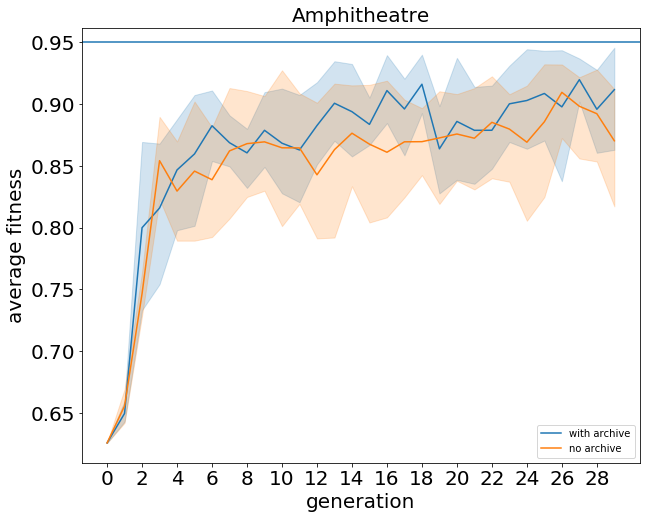

In [139]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 8 Text yticklabel objects>)

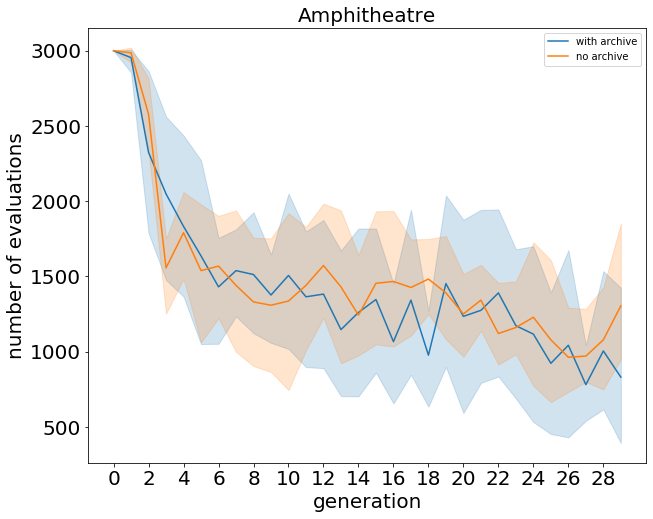

In [140]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


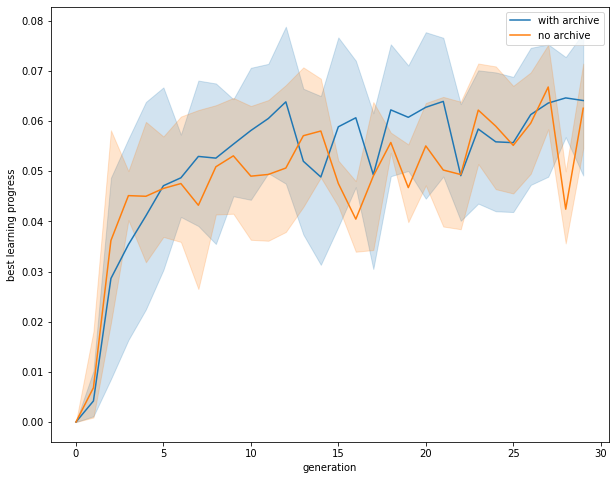

In [141]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best learning progress",label="no archive")

(array([-0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,
         0.035]),
 <a list of 9 Text yticklabel objects>)

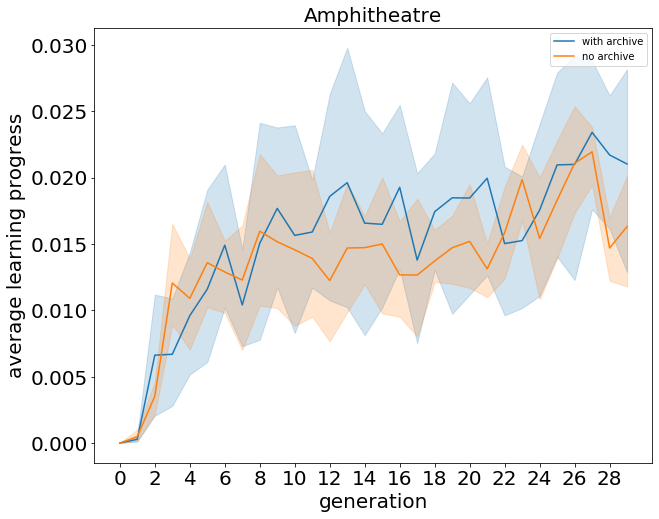

In [142]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average learning progress",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

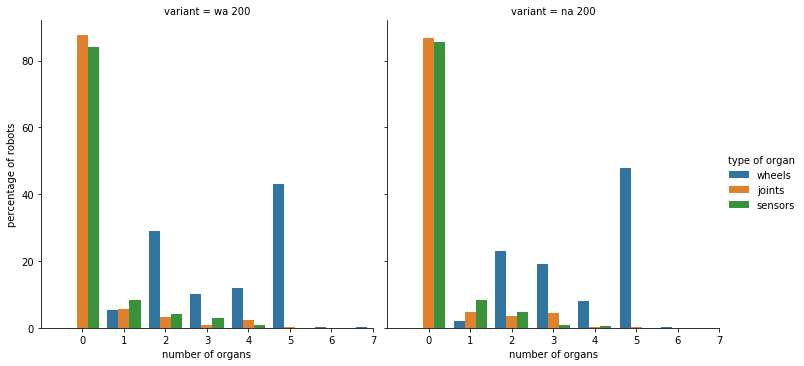

In [121]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

In [ ]:
arena="Two Paths"

In [ ]:
exp_folder = "/home/leni/are-logs/mnipes_paths_tcds/wa/200/"

In [ ]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"200",acc_nbr_eval[-1]])
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*4000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

In [35]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [36]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors",arena])

2380


In [73]:
exp_folder = "/home/leni/are-logs/mnipes_paths_tcds/na/200/"

In [45]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"200",acc_nbr_eval[-1]])

    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,ne,np.mean(lp),np.max(lp)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

30
29780


ValueError: too many values to unpack (expected 3)

In [216]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [217]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 9 Text yticklabel objects>)

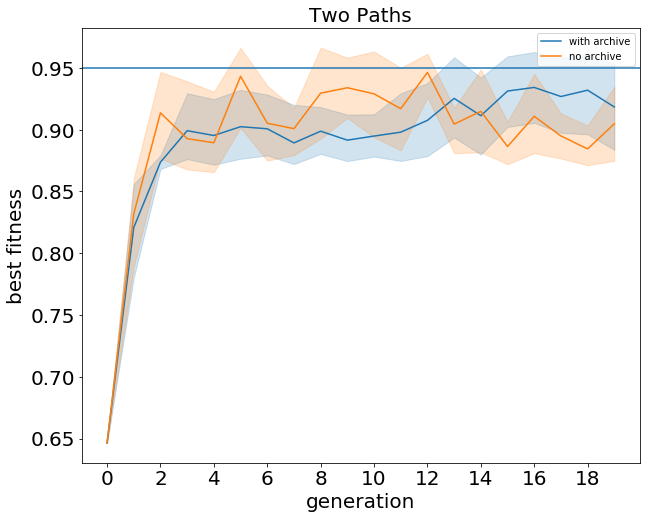

In [75]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 9 Text yticklabel objects>)

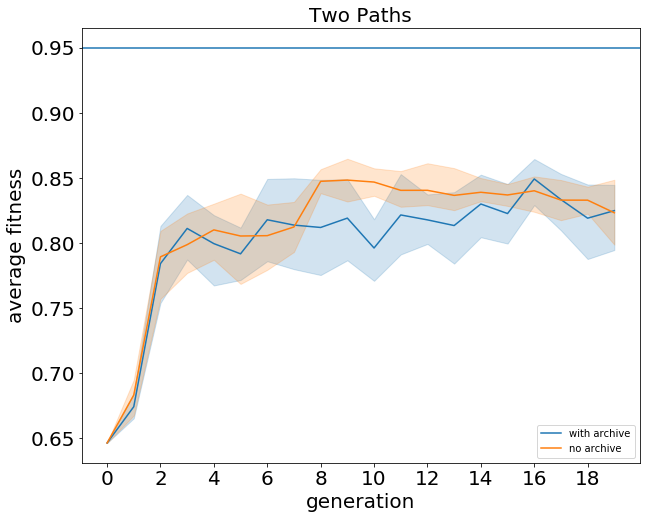

In [76]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([3000., 3500., 4000., 4500., 5000., 5500., 6000., 6500.]),
 <a list of 8 Text yticklabel objects>)

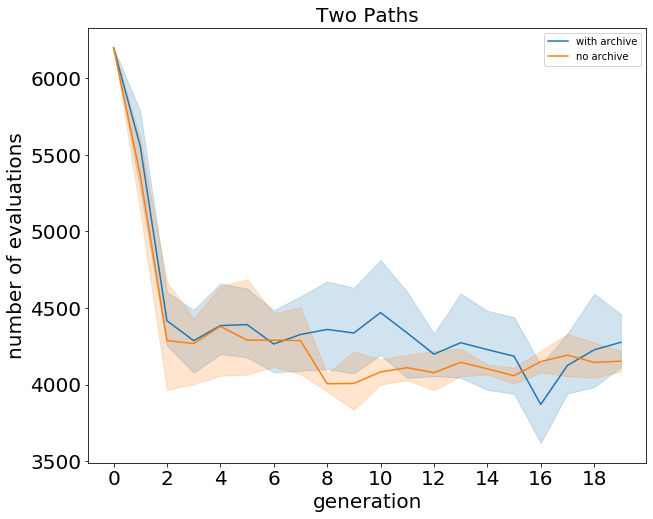

In [77]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

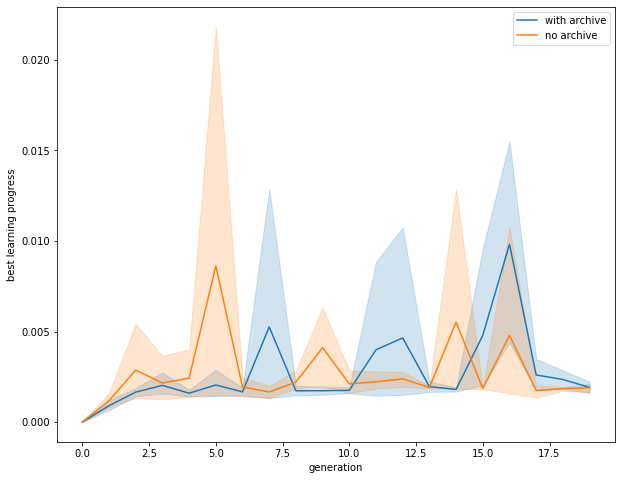

In [221]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="no archive")

(array([-0.00025,  0.     ,  0.00025,  0.0005 ,  0.00075,  0.001  ,
         0.00125,  0.0015 ,  0.00175,  0.002  ,  0.00225]),
 <a list of 11 Text yticklabel objects>)

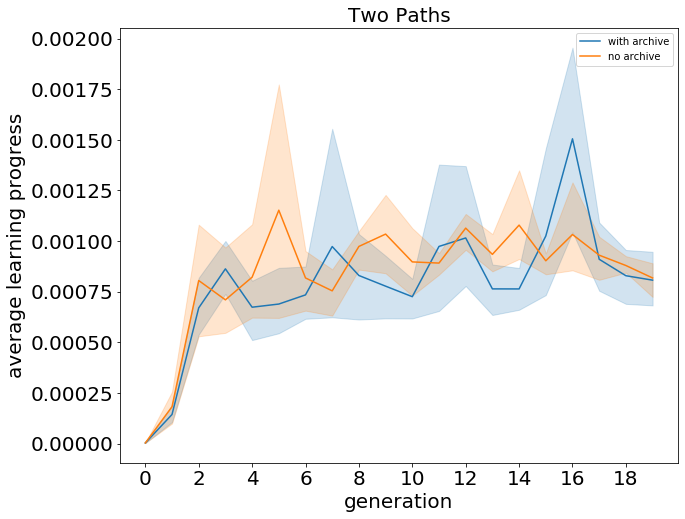

In [78]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average learning progress",label="no archive")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

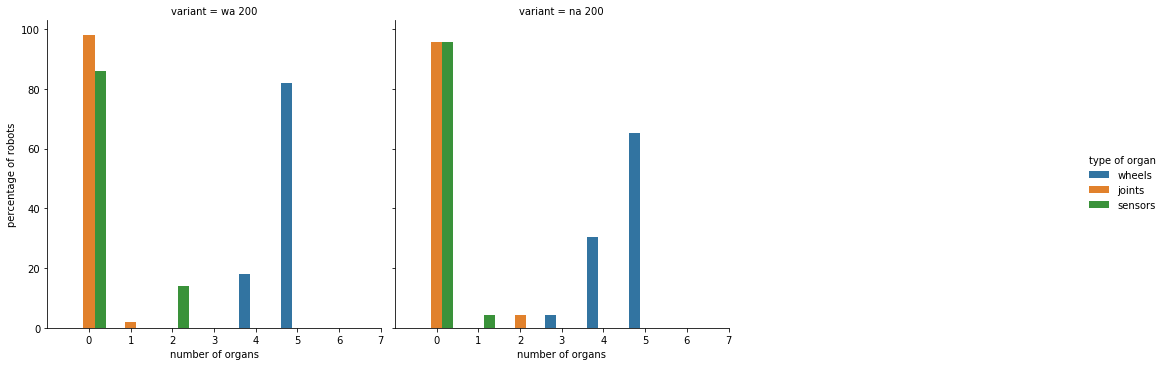

In [223]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=3)
g.set(xlim=[-1,7])

In [102]:
arena = "Hard Race"

In [47]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/wa/200/"

In [48]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 200",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    for i in range(len(fitnesses)):
        fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
            organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
            if(organ_desc in fit_per_desc[gen_v[-1]]):
                for fit in fit_per_desc[gen_v[-1]][organ_desc]:
                    diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,fd,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,fit_diff_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*4000,
                      bf,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      np.mean(fd),
                      np.max(fd),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average fitness in controller archive",
                                              "best fitness in controller archive",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

20
82290
20
83370
20
63390
20
70950
20
69230
20
78160
20
81370
20
80730
20
75720
20
75850


[36 46 73 48 46 56 42 49 49 59] 50.4 9.707728879609277


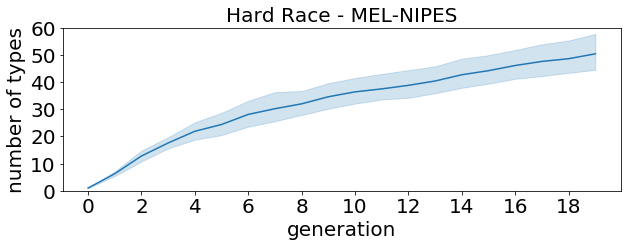

In [63]:
fig = plt.gcf()
fig.set_size_inches(10,3)
ax = sns.lineplot(data=wa_dc_data,x="generation",y="number of controllers")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of types")
ax.set_title(arena + " - MEL-NIPES",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_ylim([0,60])
nca = wa_dc_data.loc[wa_dc_data["generation"] == 19]["number of controllers"].values
print(nca,np.mean(nca),np.std(nca))

(0, 1)

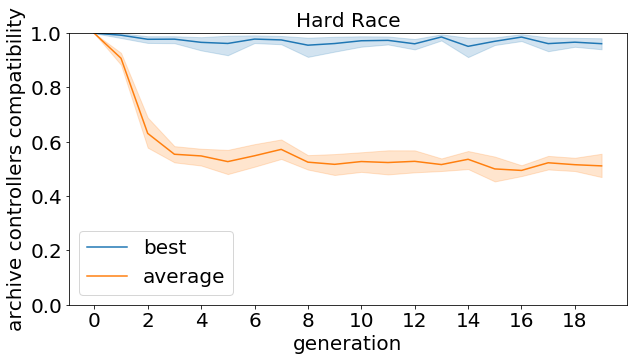

In [46]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best archive controllers compatibility",label="best")
ax = sns.lineplot(data=wa_dc_data,x="generation",y="average archive controllers compatibility",label="average")
ax.set_xticks(range(0,20,2))
ax.set_ylabel("archive controllers compatibility")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([0,1])

(0.25, 1)

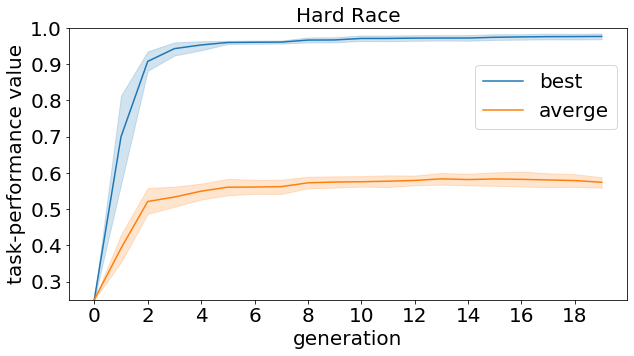

In [45]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness in controller archive",label="best")
ax = sns.lineplot(data=wa_dc_data,x="generation",y="average fitness in controller archive",label="averge")
ax.set_ylabel("task-performance value")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.0,0.9,0.0,0.0))
ax.set_ylim([0.25,1])

In [95]:
organ_lines = []
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/wa/200/"

In [96]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    #if(fit[2] >= 0.85):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])
    

[[4, 0, 0], [4, 0, 0], [3, 0, 2], [2, 0, 0], [2, 0, 0], [3, 0, 0], [2, 0, 0], [5, 0, 0], [2, 0, 0], [2, 0, 0]]


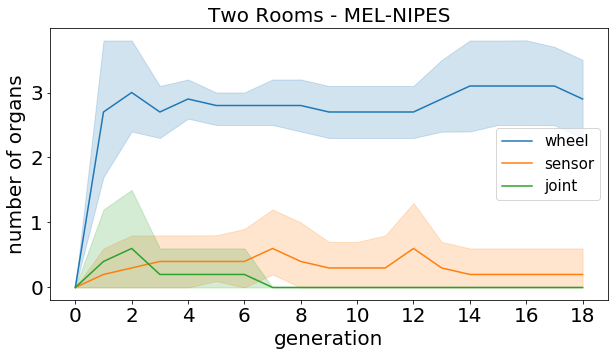

In [101]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
ax.set_xticks(range(0,20,2))
ax.set_yticks(range(4))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL-NIPES",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==18]["wheel"].values
joints_array = data.loc[data["generation"]==18]["joint"].values
sensors_array = data.loc[data["generation"]==18]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

In [117]:
exp_folder = "/home/leni/are-logs/mea_rand/hard/"

In [118]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))

    for gen, bf, af in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,gen*2000,bf,af])
rand_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness"])

41
41
41
41
41
41
41
41
41
41


In [119]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    descriptors = descOneId_to_descTwoIds(descriptors,20)
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    #if(fit[2] >= 0.85):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-LHS"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-LHS"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-LHS"])

[[3, 0, 2], [3, 0, 0], [5, 0, 2], [3, 1, 0], [4, 0, 0], [3, 0, 1], [3, 0, 0], [3, 0, 0], [5, 0, 0], [5, 0, 0]]


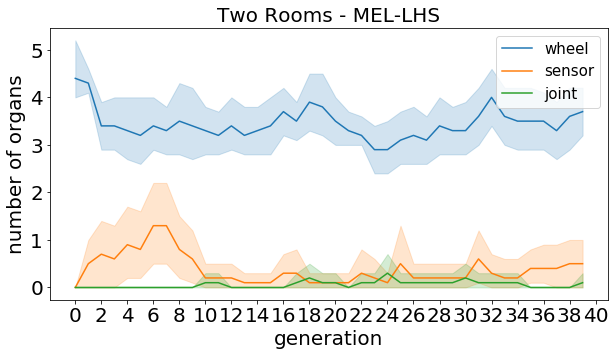

In [121]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
ax.set_xticks(range(0,42,2))
ax.set_yticks(range(6))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL-LHS",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==39]["wheel"].values
joints_array = data.loc[data["generation"]==39]["joint"].values
sensors_array = data.loc[data["generation"]==39]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

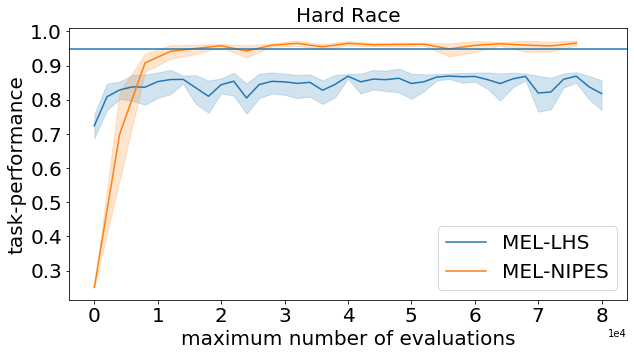

In [51]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax = sns.lineplot(data=rand_data,x="max number of evaluations",y="best fitness",label="MEL-LHS")
sns.lineplot(data=wa_dc_data,x="max number of evaluations",y="best fitness",label="MEL-NIPES")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("task-performance")
ax.set_xlabel("maximum number of evaluations")
ax.axhline(0.95)
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

<Figure size 360x360 with 0 Axes>

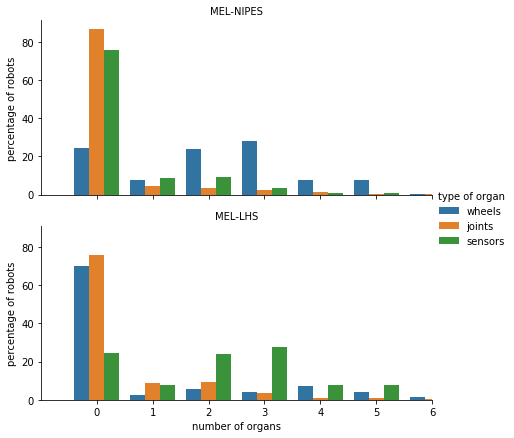

In [21]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 6))) 

[60 60 82 ... 68 57 49] 68.71847507331378 11.524079971085543


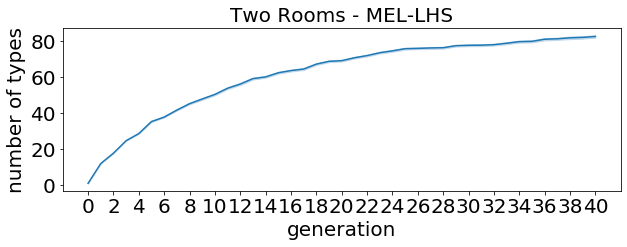

In [91]:
type_data = pd.DataFrame(data=type_lines,columns=["generation","number of types"])
fig = plt.gcf()
fig.set_size_inches(10,3)
ax = sns.lineplot(data=type_data,x="generation",y="number of types")
ax.set_xticks(range(0,42,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena + " - MEL-LHS",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
nta = type_data.loc[type_data["generation"] == 19]["number of types"].values
print(nta,np.mean(nta),np.std(nta))

In [159]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/na/200/"

In [160]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))

    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 200",bff_ne,acc_nbr_eval[-1]])

    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,init_f,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*4000,bf,np.mean(initf),np.max(initf),af,ane,ne,np.mean(lp),np.max(lp)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average initial fitness","best initial fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

20
85720
20
87790
20
83480
20
86440
20
85870
20
83610
20
85640
20
85970
20
84450
20
88580


In [96]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [97]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


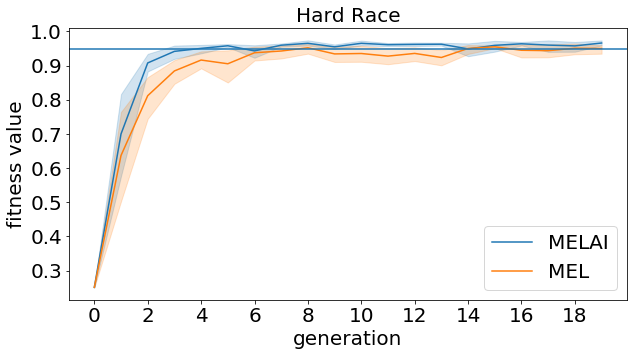

In [50]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="MEL")
ax.axhline([0.95])
ax.set_ylabel("fitness value")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)


(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 9 Text yticklabel objects>)

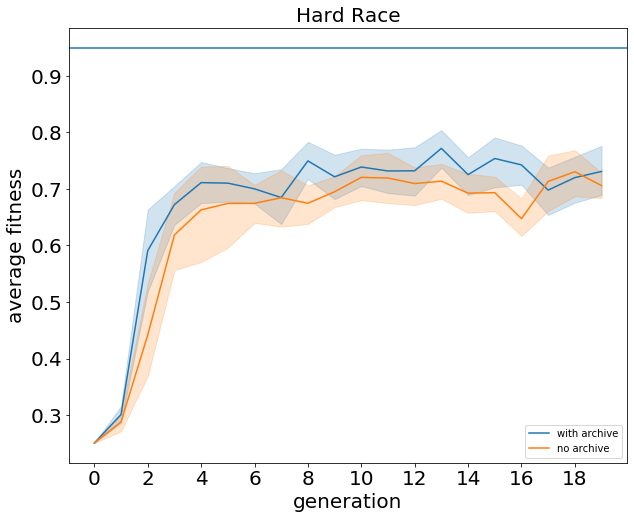

In [99]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


100
MannwhitneyuResult(statistic=17.0, pvalue=0.007009638556979976)
100
MannwhitneyuResult(statistic=2.0, pvalue=0.00016491926038899677)


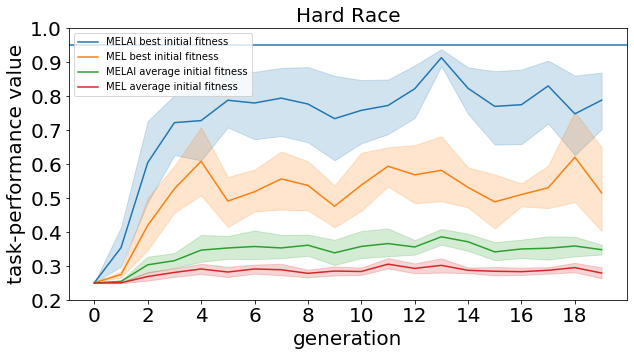

In [161]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best initial fitness",label="MELAI best initial fitness")
sns.lineplot(data=na_dc_data,x="generation",y="best initial fitness",label="MEL best initial fitness")
sns.lineplot(data=wa_dc_data,x="generation",y="average initial fitness",label="MELAI average initial fitness")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average initial fitness",label="MEL average initial fitness")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("task-performance value")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=10)
ax.set_ylim([0.2,1])
d1 = wa_dc_data[wa_dc_data["generation"]==19]["best initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["best initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
d1 = wa_dc_data[wa_dc_data["generation"]==19]["average initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["average initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

100
MannwhitneyuResult(statistic=11.0, pvalue=0.0017989434225398134)


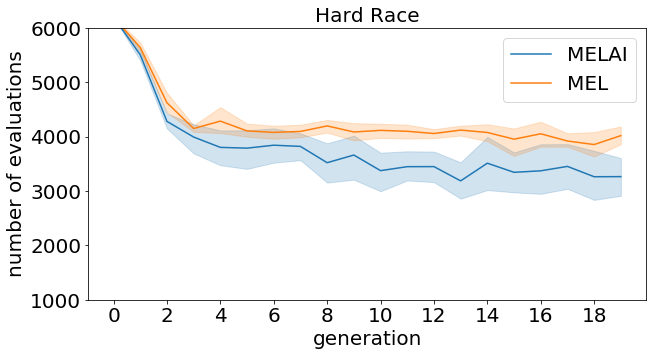

In [162]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="MEL")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([1000,6000])
d1 = wa_dc_data[wa_dc_data["generation"]==19]["number of evaluations"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["number of evaluations"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

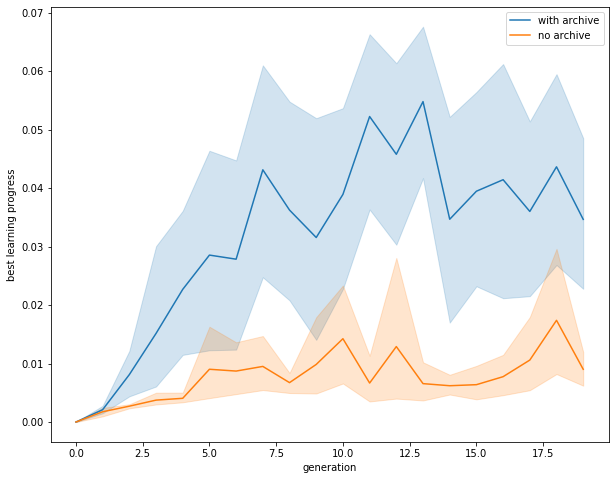

In [101]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="no archive")

100
MannwhitneyuResult(statistic=15.0, pvalue=0.004554248199015482)


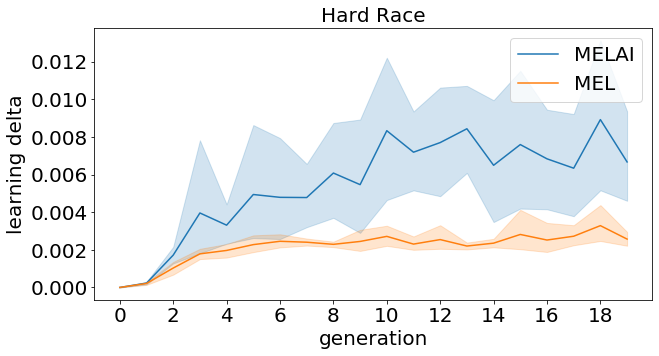

In [163]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="average learning progress",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average learning progress",label="MEL")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("learning delta")
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
d1 = wa_dc_data[wa_dc_data["generation"]==19]["average learning progress"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["average learning progress"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

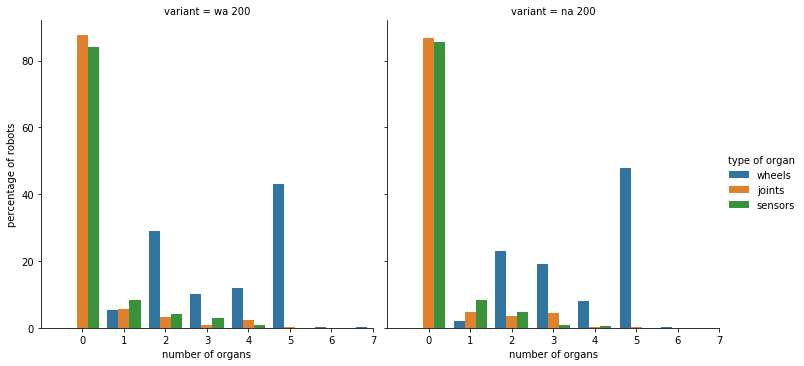

In [120]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

In [75]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/wa/150/"

In [76]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 150",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    for i in range(len(fitnesses)):
        fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
            organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
            if(organ_desc in fit_per_desc[gen_v[-1]]):
                for fit in fit_per_desc[gen_v[-1]][organ_desc]:
                    diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,fd,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,fit_diff_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*3000,
                      bf,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      np.mean(fd),
                      np.max(fd),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_cc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average fitness in controller archive",
                                              "best fitness in controller archive",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

30
76790
30
87090
30
84200
30
84980
30
87350
30
64290
30
73800
30
70950
30
85440


In [92]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [93]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","wa 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","wa 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","wa 200"])

4000


In [77]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/na/150/"

In [78]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))

    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 150",bff_ne,acc_nbr_eval[-1]])

    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,init_f,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*3000,bf,np.mean(initf),np.max(initf),af,ane,ne,np.mean(lp),np.max(lp)])
na_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average initial fitness","best initial fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

30
86670
30
87440
30
85670
30
86030
30
85690
30
89130
30
88530
30
87410
30
85860


In [96]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [97]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 10 Text yticklabel objects>)

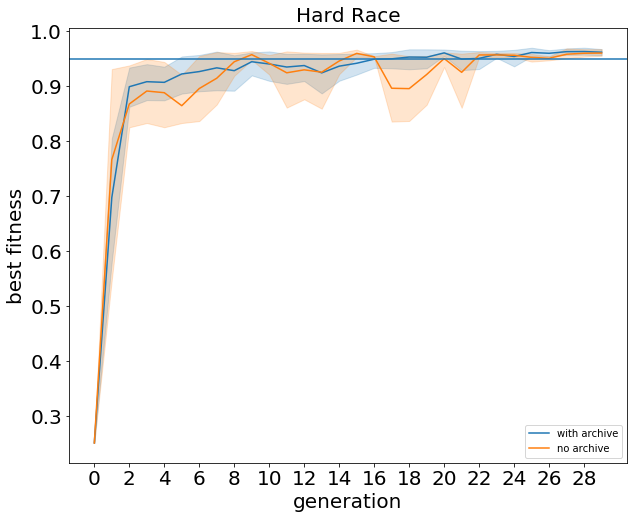

In [7]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 9 Text yticklabel objects>)

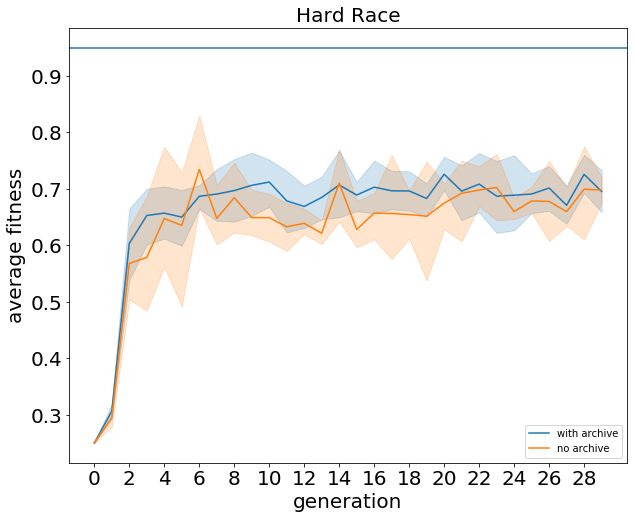

In [9]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([2000., 2200., 2400., 2600., 2800., 3000., 3200.]),
 <a list of 7 Text yticklabel objects>)

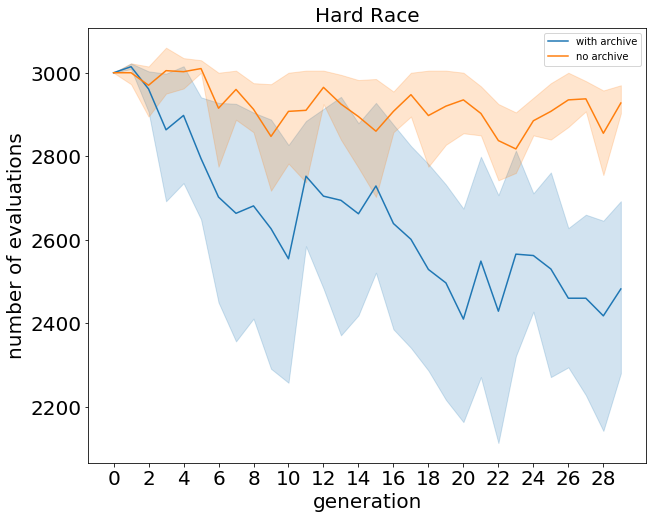

In [10]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

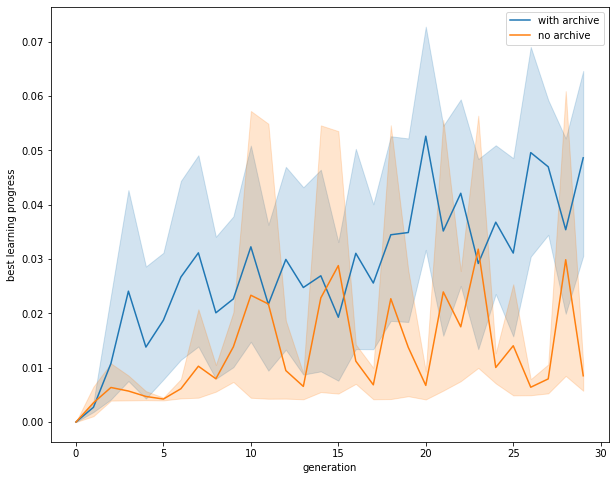

In [11]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best learning progress",label="no archive")

(array([-0.002,  0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ,  0.012,
         0.014]),
 <a list of 9 Text yticklabel objects>)

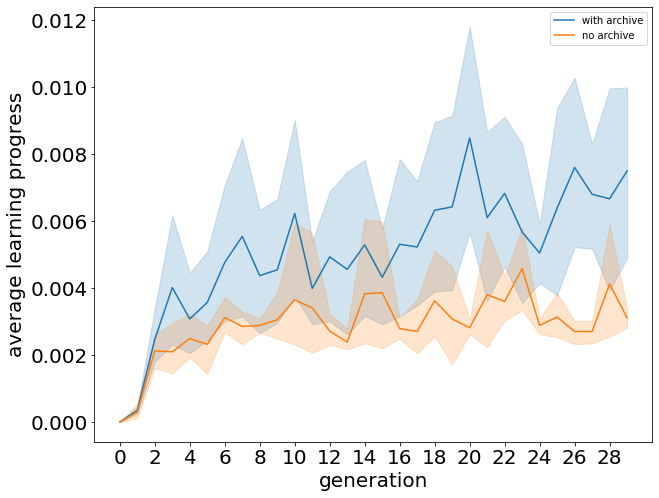

In [13]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average learning progress",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [79]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/wa/100/"

In [80]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 100",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    for i in range(len(fitnesses)):
        fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
            organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
            if(organ_desc in fit_per_desc[gen_v[-1]]):
                for fit in fit_per_desc[gen_v[-1]][organ_desc]:
                    diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,fd,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,fit_diff_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*2000,
                      bf,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      np.mean(fd),
                      np.max(fd),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_c_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average fitness in controller archive",
                                              "best fitness in controller archive",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

40
83350
40
75080
40
83700
40
81260
40
77530
40
77670
40
66830
40
76780
40
68080


In [434]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [436]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors",arena])

3200


In [81]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/na/100/"

In [82]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))

    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 100",bff_ne,acc_nbr_eval[-1]])

    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,init_f,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,np.mean(initf),np.max(initf),af,ane,ne,np.mean(lp),np.max(lp)])
na_c_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average initial fitness","best initial fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

40
84580
40
84830
40
86400
40
82680
40
76670
40
82270
40
85890
40
80700
40
79590
40
84480


In [440]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [441]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


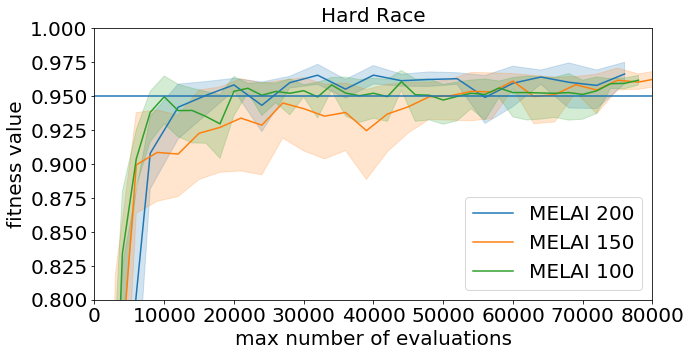

In [83]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="max number of evaluations",y="best fitness",label="MELAI 200")
sns.lineplot(data=wa_cc_data,x="max number of evaluations",y="best fitness",label="MELAI 150")
ax = sns.lineplot(data=wa_c_data,x="max number of evaluations",y="best fitness",label="MELAI 100")
ax.axhline([0.95])
ax.set_ylim([0.8,1.])
ax.set_ylabel("fitness value")
#ax.set_xticks(range(2,40,4))
ax.set_xlim([0,80000])
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

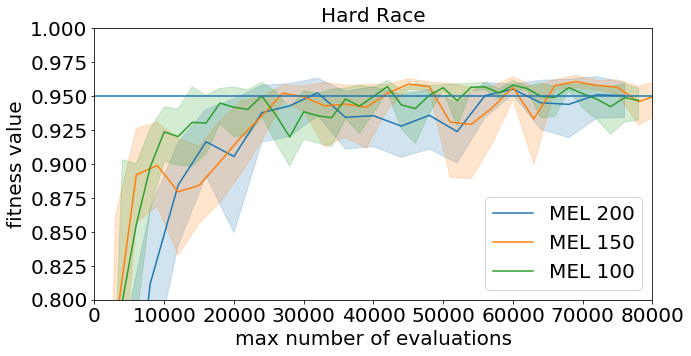

In [84]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=na_dc_data,x="max number of evaluations",y="best fitness",label="MEL 200")
sns.lineplot(data=na_cc_data,x="max number of evaluations",y="best fitness",label="MEL 150")
ax = sns.lineplot(data=na_c_data,x="max number of evaluations",y="best fitness",label="MEL 100")
ax.axhline([0.95])
ax.set_ylim([0.8,1.])
ax.set_ylabel("fitness value")
#ax.set_xticks(range(0,40,2))
ax.set_xlim([0,80000])
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 9 Text yticklabel objects>)

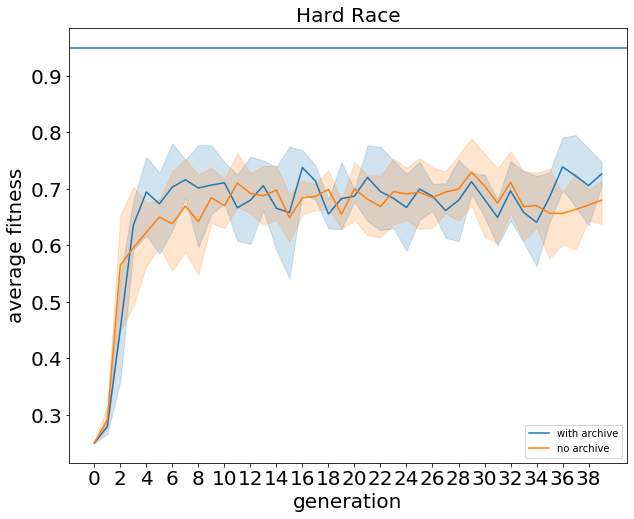

In [444]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_c_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_c_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,40,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


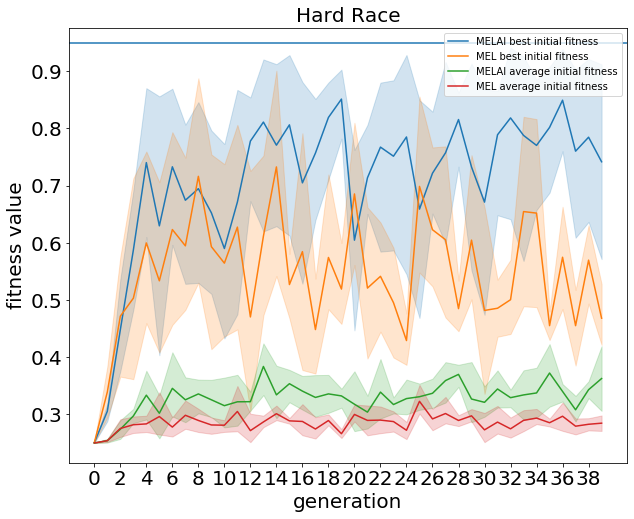

In [445]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_c_data,x="generation",y="best initial fitness",label="MELAI best initial fitness")
sns.lineplot(data=na_c_data,x="generation",y="best initial fitness",label="MEL best initial fitness")
sns.lineplot(data=wa_c_data,x="generation",y="average initial fitness",label="MELAI average initial fitness")
ax = sns.lineplot(data=na_c_data,x="generation",y="average initial fitness",label="MEL average initial fitness")
ax.axhline([0.95])
ax.set_xticks(range(0,40,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("fitness value")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=10)

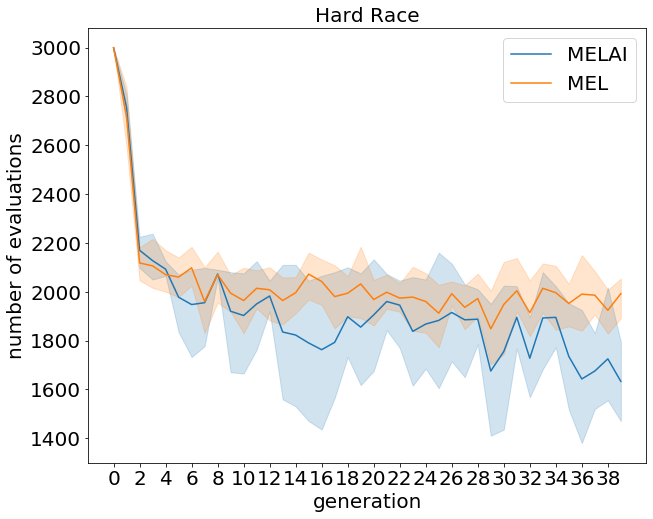

In [446]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_c_data,x="generation",y="number of evaluations",label="MELAI")
ax = sns.lineplot(data=na_c_data,x="generation",y="number of evaluations",label="MEL")
ax.set_xticks(range(0,40,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

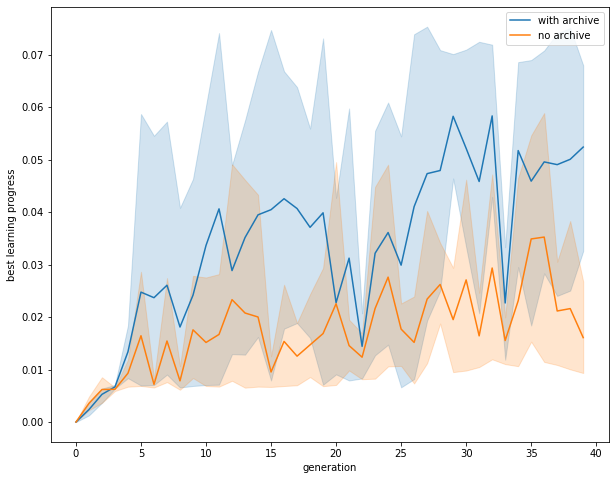

In [447]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_c_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_c_data,x="generation",y="best learning progress",label="no archive")

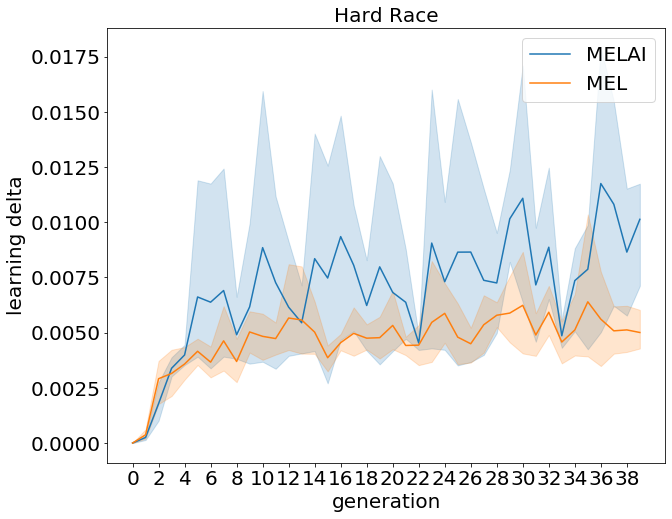

In [448]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_c_data,x="generation",y="average learning progress",label="MELAI")
ax = sns.lineplot(data=na_c_data,x="generation",y="average learning progress",label="MEL")
ax.set_xticks(range(0,40,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("learning delta")
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

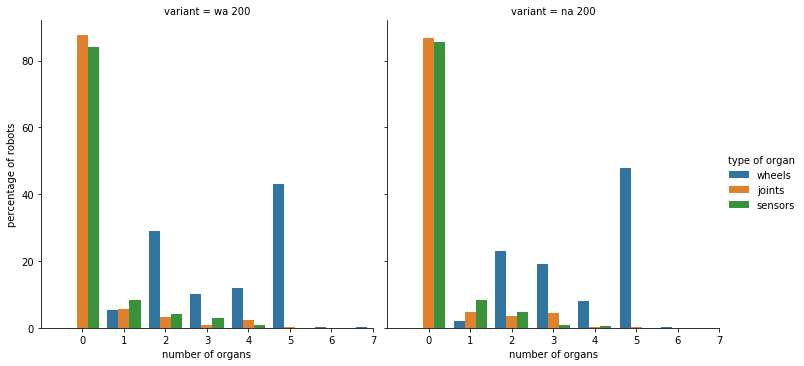

In [120]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

In [108]:
arena = "Two Rooms"

In [75]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/wa/200/"

In [76]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 200",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    for i in range(len(fitnesses)):
        fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
            organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
            if(organ_desc in fit_per_desc[gen_v[-1]]):
                for fit in fit_per_desc[gen_v[-1]][organ_desc]:
                    diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,fd,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,fit_diff_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*4000,
                      bf,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      np.mean(fd),
                      np.max(fd),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average fitness in controller archive",
                                              "best fitness in controller archive",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

20
82820
20
76210
20
88550
20
63950
20
82400
20
69230
20
81470
20
80360
20
76510
20
79780


[81 56 39 37 57 53 48 42 33 56] 50.2 13.181805642627266


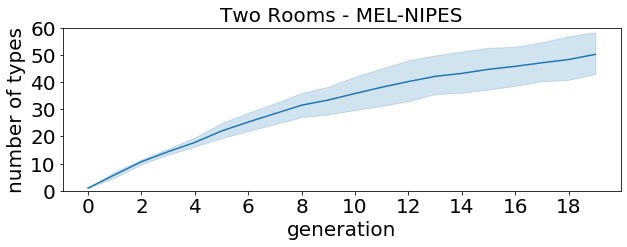

In [77]:
fig = plt.gcf()
fig.set_size_inches(10,3)
ax = sns.lineplot(data=wa_dc_data,x="generation",y="number of controllers")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of types")
ax.set_title(arena + " - MEL-NIPES",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_ylim([0,60])
nca = wa_dc_data.loc[wa_dc_data["generation"] == 19]["number of controllers"].values
print(nca,np.mean(nca),np.std(nca))

(0, 1)

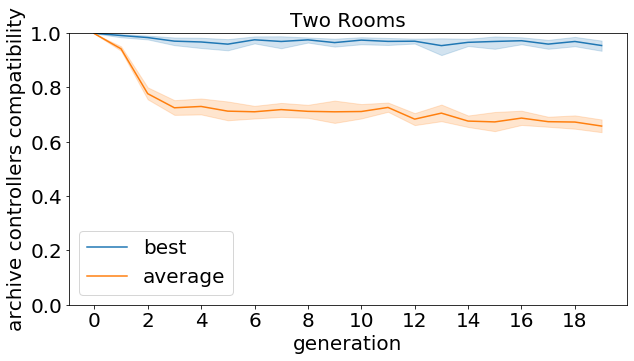

In [62]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best archive controllers compatibility",label='best')
ax = sns.lineplot(data=wa_dc_data,x="generation",y="average archive controllers compatibility",label='average')
ax.set_xticks(range(0,20,2))
ax.set_ylabel("archive controllers compatibility")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([0,1])

(0.5, 1)

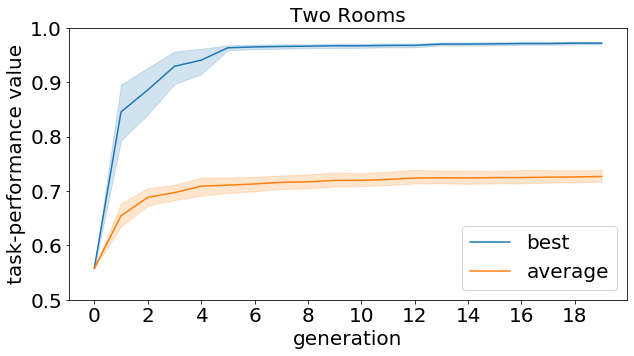

In [64]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness in controller archive",label="best")
ax = sns.lineplot(data=wa_dc_data,x="generation",y="average fitness in controller archive",label="average")
ax.set_xticks(range(0,20,2))
ax.set_ylabel("task-performance value")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([0.5,1])

In [109]:
organ_lines = []
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/wa/200/"

In [110]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    if(fit[2] >= 0.85):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

[[2, 2, 1], [2, 0, 0], [3, 0, 0], [3, 0, 0], [3, 0, 0], [2, 1, 0], [5, 0, 0], [2, 0, 0], [3, 0, 0], [2, 0, 0]]


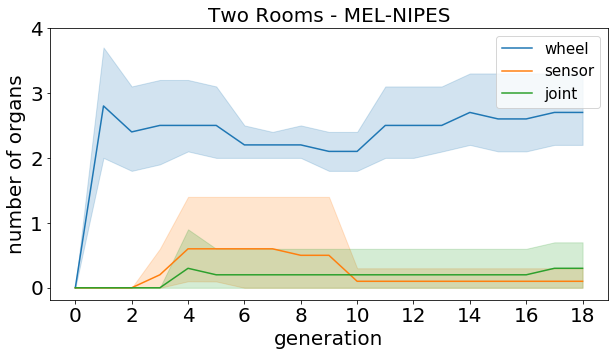

In [111]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
ax.set_xticks(range(0,20,2))
ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL-NIPES",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==18]["wheel"].values
joints_array = data.loc[data["generation"]==18]["joint"].values
sensors_array = data.loc[data["generation"]==18]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

In [112]:
exp_folder = "/home/leni/are-logs/mea_rand/room/"

In [113]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))

    for gen, bf, af in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,gen*2000,bf,af])
rand_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness"])

41
41
41
41
41
41
41
41
41
41


In [114]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    descriptors = descOneId_to_descTwoIds(descriptors,20)
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    if(fit[2] >= 0.85):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-LHS"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-LHS"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-LHS"])

In [396]:
exp_folder = "/home/leni/are-logs/mea_rand/room/"
desc1 = []
for folder in os.listdir(exp_folder):
    desc1.append(load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv"))
    desc1[-1] = descOneId_to_descTwoIds(desc1[-1],20)

exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/wa/200/"
desc2 = []
for folder in os.listdir(exp_folder):
    desc2.append(load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv"))

overlap = []
for d1, d2 in zip(desc1,desc2):
    mat = [[[0 for _ in range(16)] for _ in range(16)] for _ in range(16)]
    acc = 0
    for d in d1:
        if mat[int(d[2]*16)][int(d[3]*16)][int(d[4]*16)] == 0:
            mat[int(d[2]*16)][int(d[3]*16)][int(d[4]*16)] = 1
    for d in d2:
        if mat[int(d[2]*16)][int(d[3]*16)][int(d[4]*16)] == 1:
            acc+=1
    overlap.append(acc)
    
print(overlap,np.mean(overlap)/400*100,np.std(overlap)/400*100,40*20,20*20)
    

[194, 383, 303, 390, 351, 340, 353, 366, 263, 358] 82.525 14.42066659346925 800 400


In [397]:
exp_folder = "/home/leni/are-logs/mea_rand/hard/"
desc1 = []
for folder in os.listdir(exp_folder):
    desc1.append(load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv"))
    desc1[-1] = descOneId_to_descTwoIds(desc1[-1],20)

exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/wa/200/"
desc2 = []
for folder in os.listdir(exp_folder):
    desc2.append(load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv"))

overlap = []
for d1, d2 in zip(desc1,desc2):
    mat = [[[0 for _ in range(16)] for _ in range(16)] for _ in range(16)]
    acc = 0
    for d in d1:
        if mat[int(d[2]*16)][int(d[3]*16)][int(d[4]*16)] == 0:
            mat[int(d[2]*16)][int(d[3]*16)][int(d[4]*16)] = 1
    for d in d2:
        if mat[int(d[2]*16)][int(d[3]*16)][int(d[4]*16)] == 1:
            acc+=1
    overlap.append(acc)
    
print(overlap,np.mean(overlap)/400*100,np.std(overlap)/400*100,40*20,20*20)

[391, 381, 375, 356, 357] 93.0 3.413209633175203 800 400


[[4, 0, 2], [2, 1, 0], [2, 0, 0], [2, 0, 0], [3, 0, 0], [2, 0, 2], [5, 0, 0], [2, 0, 2], [6, 0, 2], [3, 0, 0]]


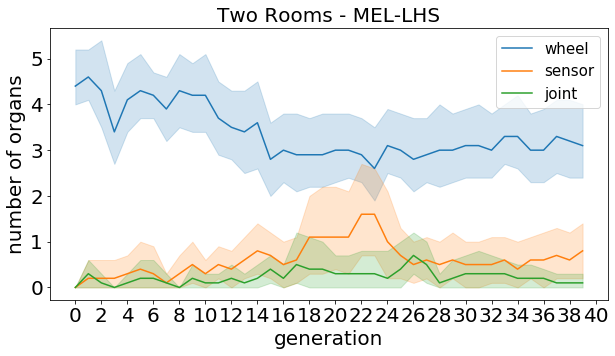

In [116]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
ax.set_xticks(range(0,42,2))
ax.set_yticks(range(6))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL-LHS",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==39]["wheel"].values
joints_array = data.loc[data["generation"]==39]["joint"].values
sensors_array = data.loc[data["generation"]==39]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

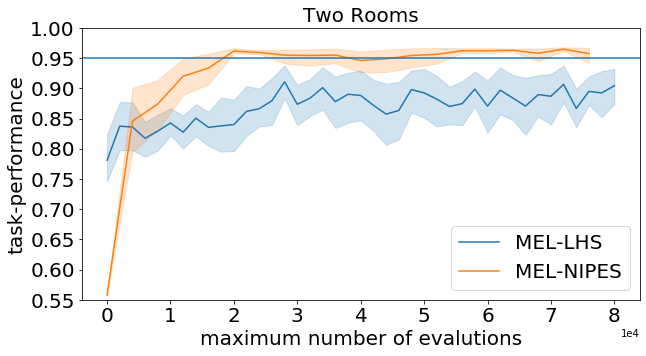

In [43]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax = sns.lineplot(data=rand_data,x="max number of evaluations",y="best fitness",label="MEL-LHS")
sns.lineplot(data=wa_dc_data,x="max number of evaluations",y="best fitness",label="MEL-NIPES")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylim(0.55,1)
ax.axhline(0.95)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("task-performance")
ax.set_xlabel("maximum number of evalutions")
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

<Figure size 360x360 with 0 Axes>

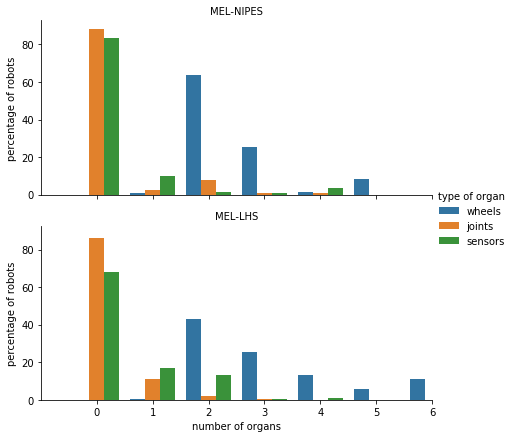

In [390]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 6))) 

[63 63 67 ... 47 59 60] 63.012707722385144 5.183705841936565


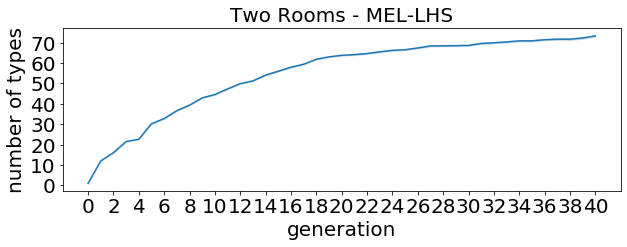

In [85]:
type_data = pd.DataFrame(data=type_lines,columns=["generation","number of types"])
fig = plt.gcf()
fig.set_size_inches(10,3)
ax = sns.lineplot(data=type_data,x="generation",y="number of types")
ax.set_xticks(range(0,42,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena + " - MEL-LHS",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
nta = type_data.loc[type_data["generation"] == 19]["number of types"].values
print(nta,np.mean(nta),np.std(nta))

In [167]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/na/200/"

In [168]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))

    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 200",bff_ne,acc_nbr_eval[-1]])
            
    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f, avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*4000,
                      bf, 
                      np.mean(initf), 
                      np.max(initf), 
                      af,
                      ane,
                      ne,
                      np.mean(lp),
                      np.max(lp)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

20
82100
20
90170
20
85240
20
83190
20
84260
20
87110
20
82750
20
83440
20
89890
20
84550


In [9]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [10]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


(0.5, 1)

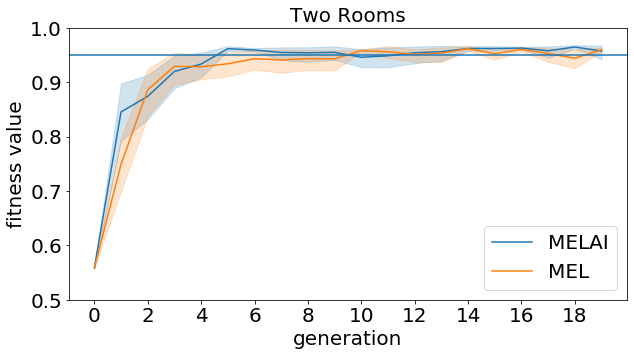

In [67]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="MEL")
ax.axhline([0.95])
ax.set_ylabel("fitness value")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([0.5,1])

(array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 11 Text yticklabel objects>)

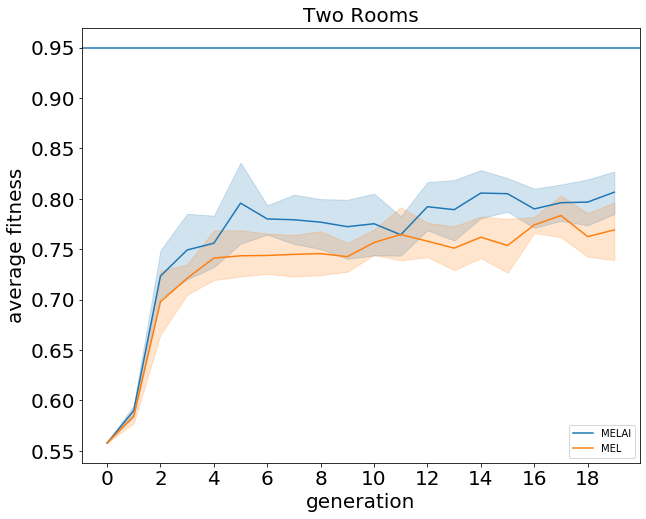

In [358]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="MEL")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

100
MannwhitneyuResult(statistic=10.0, pvalue=0.0014136360455584039)
100
MannwhitneyuResult(statistic=31.0, pvalue=0.08098620524006306)


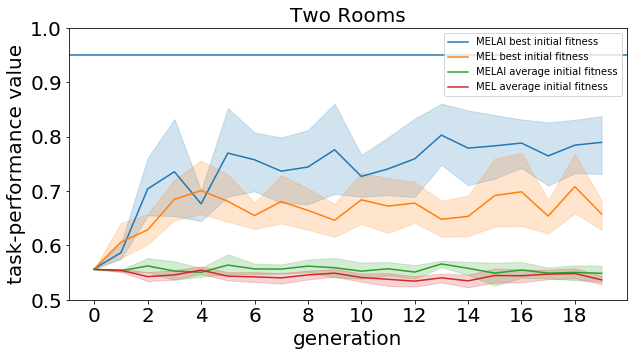

In [170]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best initial fitness",label="MELAI best initial fitness")
sns.lineplot(data=na_dc_data,x="generation",y="best initial fitness",label="MEL best initial fitness")
sns.lineplot(data=wa_dc_data,x="generation",y="average initial fitness",label="MELAI average initial fitness")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average initial fitness",label="MEL average initial fitness")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("task-performance value")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=10)
ax.set_ylim([0.5,1])
d1 = wa_dc_data[wa_dc_data["generation"]==19]["best initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["best initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
d1 = wa_dc_data[wa_dc_data["generation"]==19]["average initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["average initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

100
MannwhitneyuResult(statistic=32.0, pvalue=0.09269007167775994)


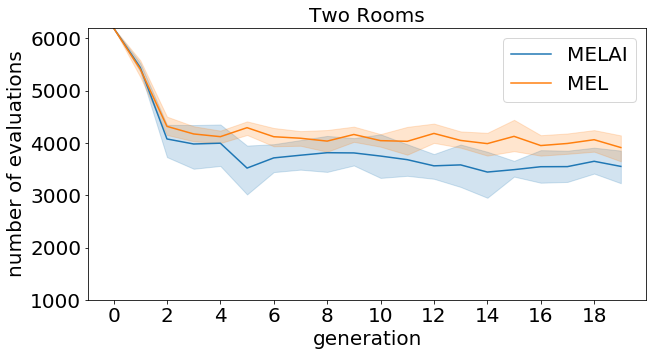

In [171]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="MEL")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([1000,6200])
d1 = wa_dc_data[wa_dc_data["generation"]==19]["number of evaluations"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["number of evaluations"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

(array([-0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,
         0.035,  0.04 ,  0.045]),
 <a list of 11 Text yticklabel objects>)

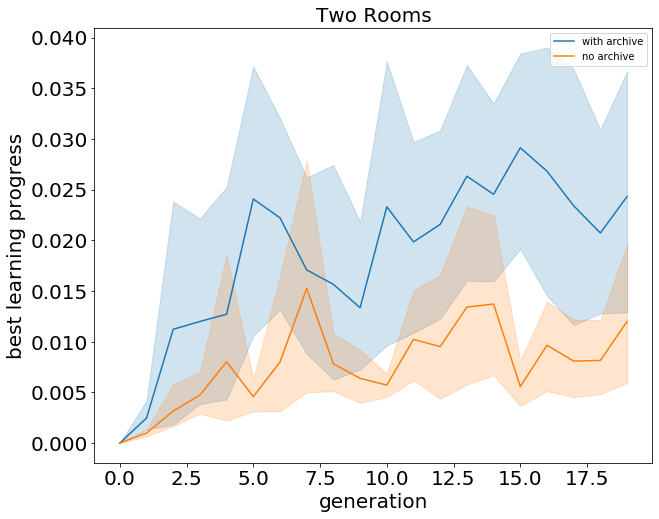

In [50]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="no archive")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

100
MannwhitneyuResult(statistic=25.0, pvalue=0.032011050641513446)


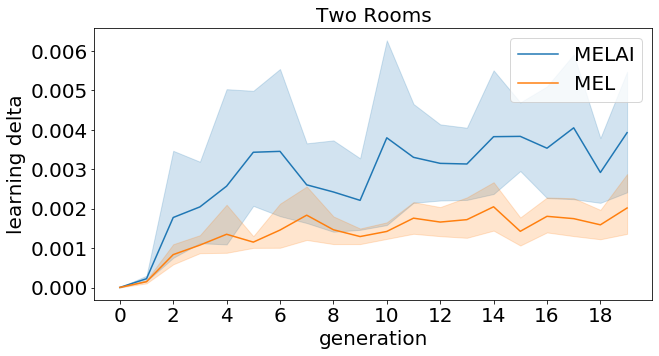

In [195]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="average learning progress",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average learning progress",label="MEL")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xticks(range(0,20,2))
ax.set_title(arena,fontsize=20)
ax.set_ylabel("learning delta")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
d1 = wa_dc_data[wa_dc_data["generation"]==19]["average learning progress"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["average learning progress"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

In [52]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

ValueError: min() arg is an empty sequence

In [92]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/wa/150/"

In [93]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 150",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    for i in range(len(fitnesses)):
        fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
            organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
            if(organ_desc in fit_per_desc[gen_v[-1]]):
                for fit in fit_per_desc[gen_v[-1]][organ_desc]:
                    diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,fd,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,fit_diff_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*3000,
                      bf,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      np.mean(fd),
                      np.max(fd),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_cc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average fitness in controller archive",
                                              "best fitness in controller archive",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

30
77660
30
87210
30
75460
30
76630
30
85730
30
79970
30
82620
30
86740
30
81240


In [16]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [6]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","wa 150"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","wa 150"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","wa 150"])

4000


In [94]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/na/150/"

In [95]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))

    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 150",bff_ne,acc_nbr_eval[-1]])
            
    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f, avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*3000,
                      bf, 
                      np.mean(initf), 
                      np.max(initf), 
                      af,
                      ane,
                      ne,
                      np.mean(lp),
                      np.max(lp)])
na_cc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

30
87720
30
88240
30
82680
30
84850
30
87500
30
86930
30
88160
30
84360
30
86590
30
87870


In [9]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [10]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 10 Text yticklabel objects>)

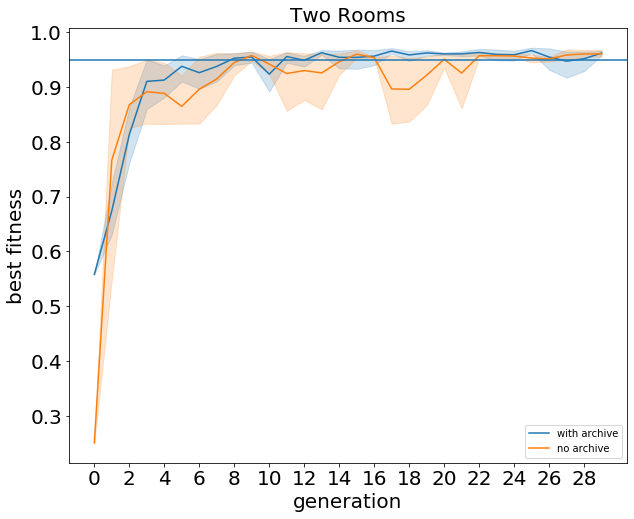

In [541]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 11 Text yticklabel objects>)

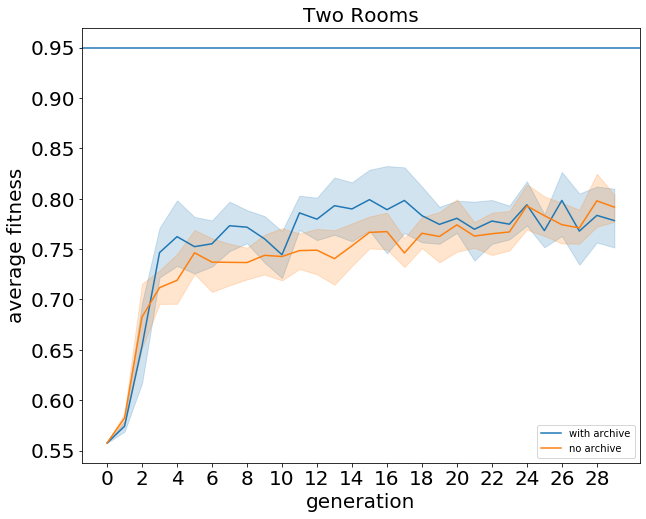

In [231]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([2000., 2200., 2400., 2600., 2800., 3000., 3200.]),
 <a list of 7 Text yticklabel objects>)

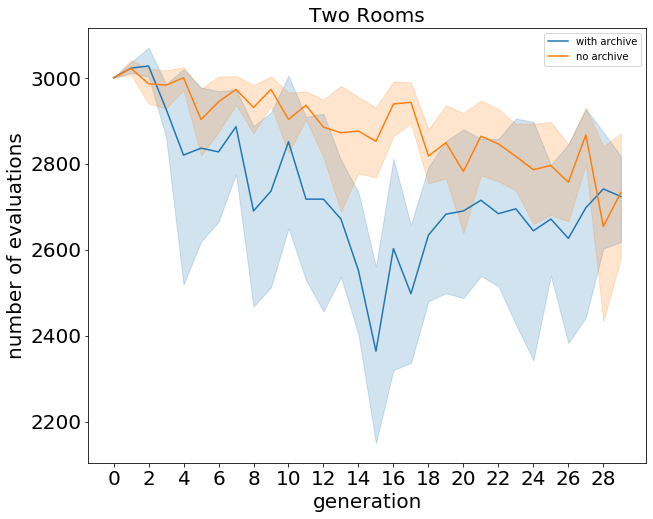

In [232]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06]),
 <a list of 8 Text yticklabel objects>)

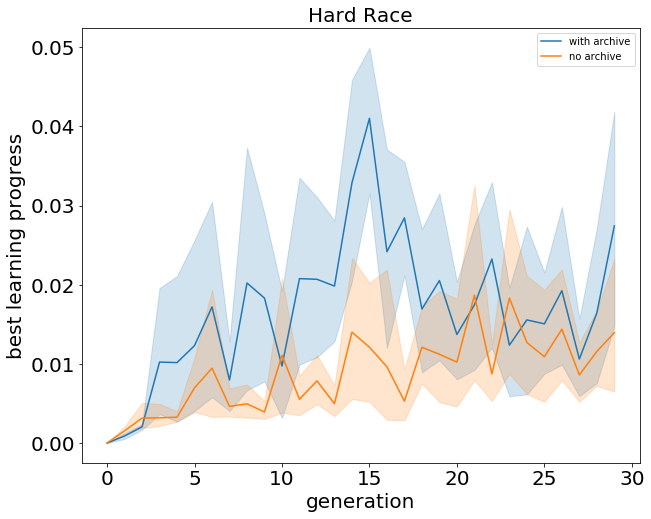

In [22]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best learning progress",label="no archive")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-0.002,  0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ]),
 <a list of 7 Text yticklabel objects>)

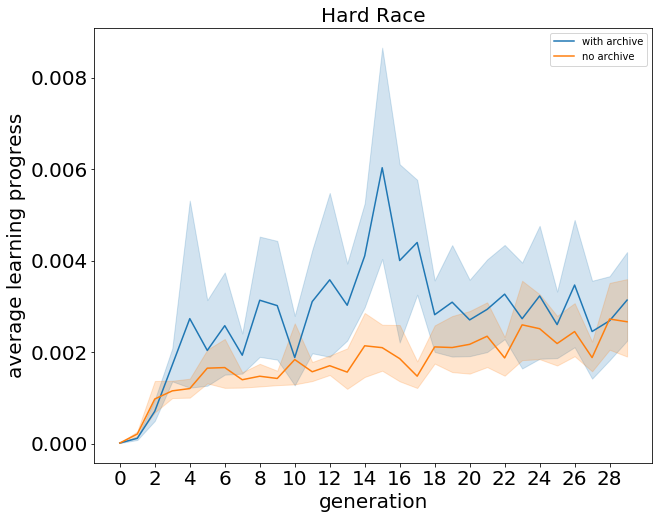

In [24]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average learning progress",label="no archive")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xticks(range(0,30,2))
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [96]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/wa/100/"

In [97]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 100",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    for i in range(len(fitnesses)):
        fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
            organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
            if(organ_desc in fit_per_desc[gen_v[-1]]):
                for fit in fit_per_desc[gen_v[-1]][organ_desc]:
                    diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,fd,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,fit_diff_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*2000,
                      bf,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      np.mean(fd),
                      np.max(fd),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_c_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average fitness in controller archive",
                                              "best fitness in controller archive",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

40
80630
40
76710
40
74340
40
81890
40
77920
40
76500
40
84140
40
78150
40
77130


In [452]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [453]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors",arena])

3200


In [98]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/na/100/"

In [99]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))

    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 100",bff_ne,acc_nbr_eval[-1]])
            
    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f, avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      gen*2000,
                      bf, 
                      np.mean(initf), 
                      np.max(initf), 
                      af,
                      ane,
                      ne,
                      np.mean(lp),
                      np.max(lp)])
na_c_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

40
85070
40
84190
40
83790
40
83680
40
84450
40
83390
40
86010
40
85250
40
87060
40
82940


In [464]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [465]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


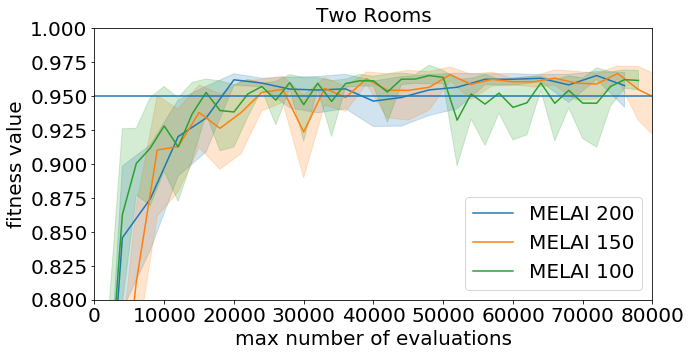

In [100]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="max number of evaluations",y="best fitness",label="MELAI 200")
sns.lineplot(data=wa_cc_data,x="max number of evaluations",y="best fitness",label="MELAI 150")
ax = sns.lineplot(data=wa_c_data,x="max number of evaluations",y="best fitness",label="MELAI 100")
ax.axhline([0.95])
ax.set_ylim([0.8,1.])
ax.set_ylabel("fitness value")
#ax.set_xticks(range(2,40,4))
ax.set_xlim([0,80000])
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

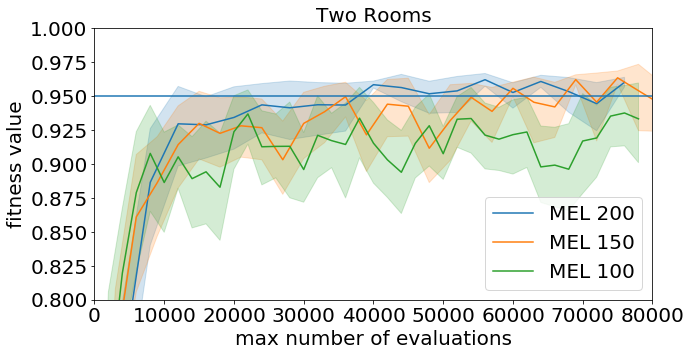

In [101]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=na_dc_data,x="max number of evaluations",y="best fitness",label="MEL 200")
sns.lineplot(data=na_cc_data,x="max number of evaluations",y="best fitness",label="MEL 150")
ax = sns.lineplot(data=na_c_data,x="max number of evaluations",y="best fitness",label="MEL 100")
ax.axhline([0.95])
ax.set_ylim([0.8,1.])
ax.set_ylabel("fitness value")
#ax.set_xticks(range(0,40,2))
ax.set_xlim([0,80000])
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

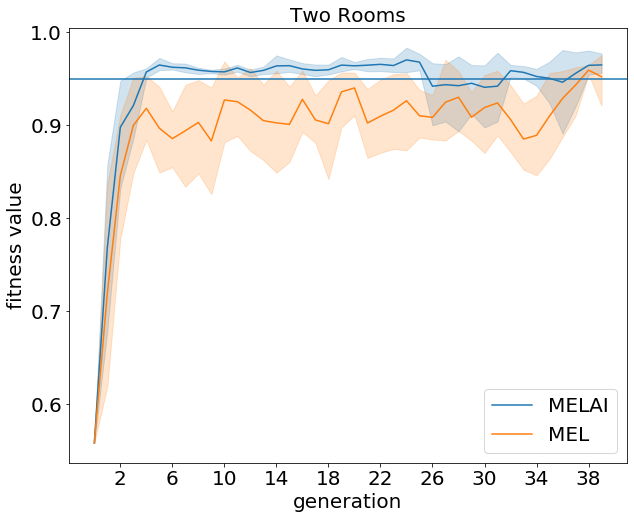

In [472]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_c_data,x="generation",y="best fitness",label="MELAI")
ax = sns.lineplot(data=na_c_data,x="generation",y="best fitness",label="MEL")
ax.axhline([0.95])
ax.set_ylabel("fitness value")
ax.set_xticks(range(2,40,4))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

(array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 11 Text yticklabel objects>)

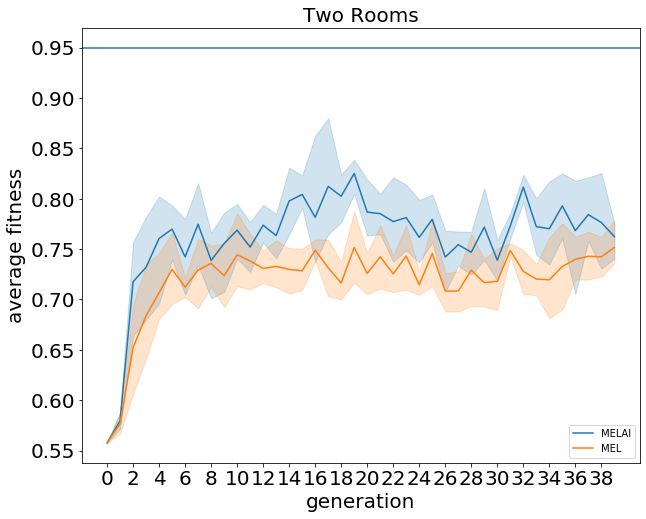

In [467]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_c_data,x="generation",y="average fitness",label="MELAI")
ax = sns.lineplot(data=na_c_data,x="generation",y="average fitness",label="MEL")
ax.axhline([0.95])
ax.set_xticks(range(0,40,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

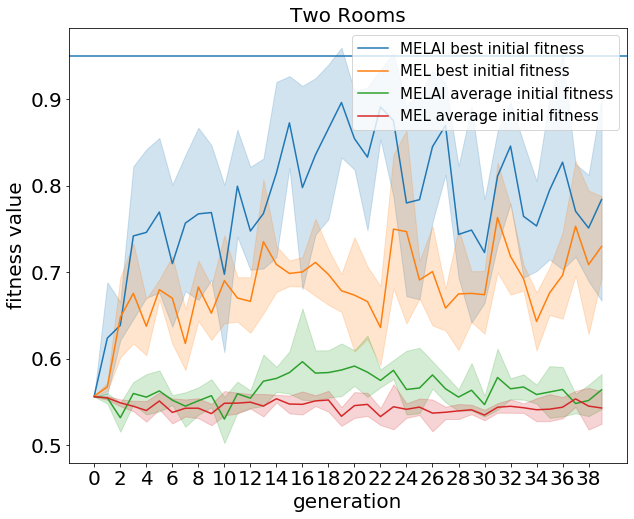

In [468]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_c_data,x="generation",y="best initial fitness",label="MELAI best initial fitness")
sns.lineplot(data=na_c_data,x="generation",y="best initial fitness",label="MEL best initial fitness")
sns.lineplot(data=wa_c_data,x="generation",y="average initial fitness",label="MELAI average initial fitness")
ax = sns.lineplot(data=na_c_data,x="generation",y="average initial fitness",label="MEL average initial fitness")
ax.axhline([0.95])
ax.set_xticks(range(0,40,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("fitness value")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

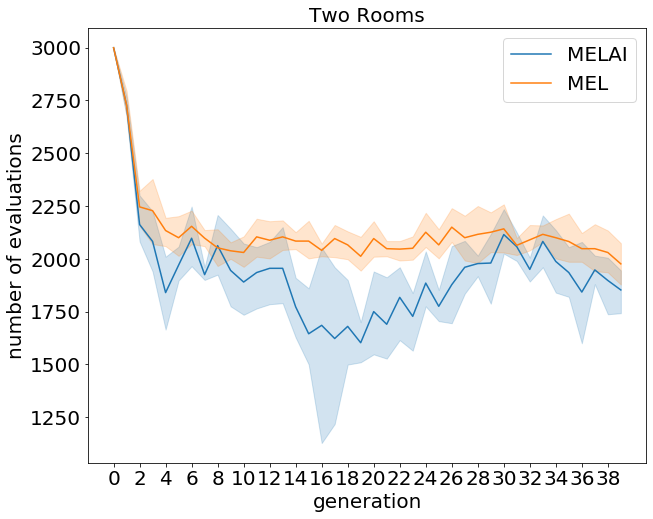

In [469]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_c_data,x="generation",y="number of evaluations",label="MELAI")
ax = sns.lineplot(data=na_c_data,x="generation",y="number of evaluations",label="MEL")
ax.set_xticks(range(0,40,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06]),
 <a list of 8 Text yticklabel objects>)

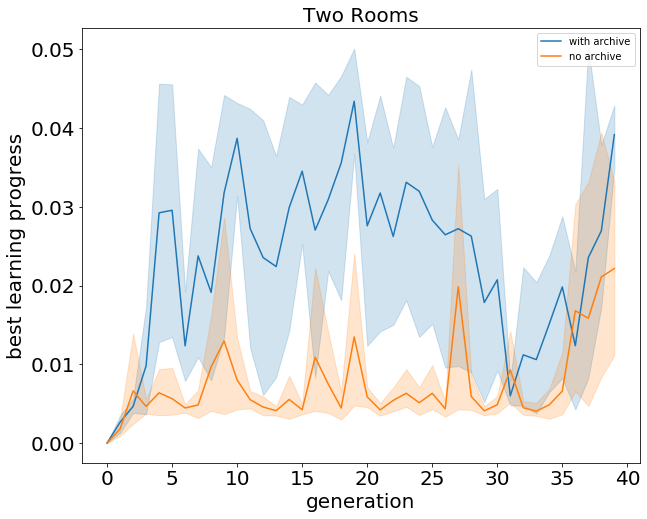

In [470]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_c_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_c_data,x="generation",y="best learning progress",label="no archive")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

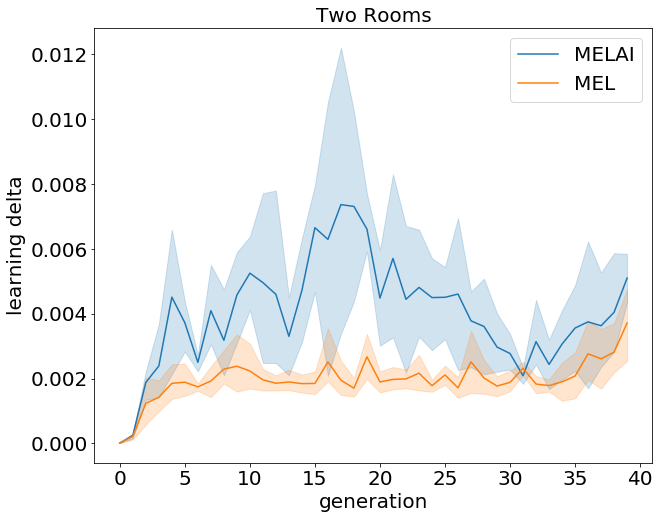

In [471]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_c_data,x="generation",y="average learning progress",label="MELAI")
ax = sns.lineplot(data=na_c_data,x="generation",y="average learning progress",label="MEL")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("learning delta")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

<Figure size 360x360 with 0 Axes>

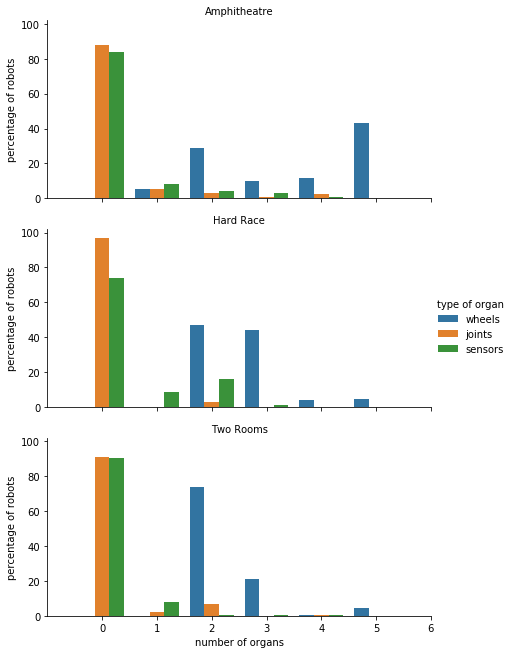

In [194]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 6))) 

197


Text(1.0, 61894, 'ns')

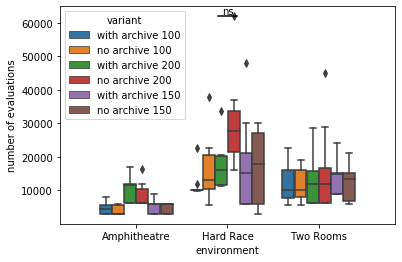

In [140]:
fig = plt.gcf()
fig.set_size_inches(6, 4)
nb_eval_data = pd.DataFrame(data=nb_eval_lines,columns=["environment","variant","number of evaluations","total number of evaluations"])
print(len(nb_eval_data))
ax = sns.boxplot(data=nb_eval_data,x="environment",y="number of evaluations",hue="variant")
x1, x2 = 0.9, 1.1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = nb_eval_data["number of evaluations"].max() + 2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
#ax.set_ylim([0,90000])

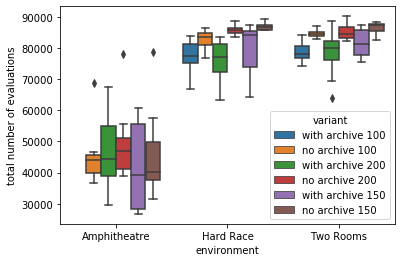

In [115]:
fig = plt.gcf()
fig.set_size_inches(6, 4)
ax = sns.boxplot(data=nb_eval_data,x="environment",y="total number of evaluations",hue="variant")
#ax.set_ylim([,90000])